# Data preprocessing
Skyler Szot (sls2305) and Mark Morrissey (mm5839)

This notebook preprocesses the entire MAIAC dataset and saves the results to csv.

We process the entire ~80GB down to around 3GB, making the data much more managable. The data preprocessing is very time consuming taking ~20 hours to run this notebook, but this step only needs to be performed once.

In [1]:
from pathlib import Path
import random
from typing import Dict, List, Union

from cloudpathlib import S3Path
import geopandas as gpd
import pandas as pd
import rasterio

#MAIAC imports
import os
import re

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from pyhdf.SD import SD, SDC, SDS
import pyproj

#alignment import
from pyproj import CRS, Proj

#other imports
from pqdm.processes import pqdm

#raster transforms imports
from rasterio.transform import Affine
from rasterio.warp import reproject, Resampling

#model imports
from sklearn.ensemble import RandomForestRegressor

#MAIAC line
mpl.rcParams['figure.dpi'] = 100

#data lines
DATA_PATH = Path.cwd() / "data"
RAW = DATA_PATH / "raw"
INTERIM = DATA_PATH / "interim"

print(DATA_PATH)
print(RAW)
print(INTERIM)

C:\Users\Skyler\data
C:\Users\Skyler\data\raw
C:\Users\Skyler\data\interim


### read in metadata csv files

In [2]:
pm_md = pd.read_csv(
    RAW / "pm25_satellite_metadata.csv",
    parse_dates=["time_start", "time_end"],
    index_col=0
)

grid_md = pd.read_csv(
    RAW / "grid_metadata.csv",
    index_col=0
)

### Get info on MAIAC training data

In [3]:
maiac_md = pm_md[(pm_md["product"] == "maiac") & (pm_md["split"] == "train")].copy()
maiac_md.shape

(4260, 10)

In [4]:
maiac_md.head(3)

,time_start,time_end,product,location,split,us_url,eu_url,as_url,cksum,granule_size
granule_id,,,,,,,,,,
20180201T191000_maiac_la_0.hdf,2018-02-01 17:25:00+00:00,2018-02-01 19:10:00+00:00,maiac,la,train,s3://drivendata-competition-airathon-public-us...,s3://drivendata-competition-airathon-public-eu...,s3://drivendata-competition-airathon-public-as...,911405771,10446736
20180202T195000_maiac_la_0.hdf,2018-02-02 18:05:00+00:00,2018-02-02 19:50:00+00:00,maiac,la,train,s3://drivendata-competition-airathon-public-us...,s3://drivendata-competition-airathon-public-eu...,s3://drivendata-competition-airathon-public-as...,2244451908,11090180
20180203T203000_maiac_la_0.hdf,2018-02-03 17:10:00+00:00,2018-02-03 20:30:00+00:00,maiac,la,train,s3://drivendata-competition-airathon-public-us...,s3://drivendata-competition-airathon-public-eu...,s3://drivendata-competition-airathon-public-as...,3799527997,12468482


### Get counts of files for each location
TPE has twice as many because two separate orbit tracks bisect Taipei

There is approximately an even distribution of files by year and by month

In [5]:
maiac_md.location.value_counts()

tpe    2130
la     1065
dl     1065
Name: location, dtype: int64

In [6]:
maiac_md.time_end.dt.year.value_counts()

2020    1464
2019    1460
2018    1336
Name: time_end, dtype: int64

In [7]:
maiac_md.time_end.dt.month.value_counts().sort_index()

1     248
2     340
3     372
4     360
5     372
6     360
7     372
8     372
9     360
10    372
11    360
12    372
Name: time_end, dtype: int64

### describe time distribution
Files range from 5 minutes to over 14 hours, with an average of 1.5 hours

In [8]:
(maiac_md.time_end - maiac_md.time_start).describe()

count                         4260
mean     0 days 01:27:16.549295774
std      0 days 00:55:30.276180728
min                0 days 00:05:00
25%                0 days 00:10:00
50%                0 days 01:45:00
75%                0 days 01:45:00
max                0 days 14:20:00
dtype: object

### Grid metadata
each grid has a unique grid_id, and there are 54 total grids. Delhi has 33 grids, LA has 14, and Taipei has 7

In [9]:
grid_md.head(3)

,location,tz,wkt
grid_id,,,
1X116,Taipei,Asia/Taipei,"POLYGON ((121.5257644471362 24.97766123020391,..."
1Z2W7,Delhi,Asia/Calcutta,"POLYGON ((77.30453178416276 28.54664454217707,..."
3S31A,Los Angeles (SoCAB),Etc/GMT+8,POLYGON ((-117.9338248256995 33.79558357488509...


In [10]:
grid_md.shape

(54, 3)

In [11]:
grid_md.location.value_counts()

Delhi                  33
Los Angeles (SoCAB)    14
Taipei                  7
Name: location, dtype: int64

### Define the filepath to the raw hdf data
The full 80GB data was downloaded in advance to local device

In [12]:
la_file = maiac_md[maiac_md.location == "la"].iloc[0]
dl_file = maiac_md[maiac_md.location == "dl"].iloc[0]
tpe_file = maiac_md[maiac_md.location == "tpe"].iloc[0]

print(la_file)
print()
la_file_path = str(la_file['split']) + "/" + str(la_file['product']) + "/" + str(la_file['time_start'].year) + "/" + str(la_file.name)
dl_file_path = str(dl_file['split']) + "/" + str(dl_file['product']) + "/" + str(dl_file['time_start'].year) + "/" + str(dl_file.name)
tpe_file_path = str(tpe_file['split']) + "/" + str(tpe_file['product']) + "/" + str(tpe_file['time_start'].year) + "/" + str(tpe_file.name)

print(la_file_path)

time_start                              2018-02-01 17:25:00+00:00
time_end                                2018-02-01 19:10:00+00:00
product                                                     maiac
location                                                       la
split                                                       train
us_url          s3://drivendata-competition-airathon-public-us...
eu_url          s3://drivendata-competition-airathon-public-eu...
as_url          s3://drivendata-competition-airathon-public-as...
cksum                                                   911405771
granule_size                                             10446736
Name: 20180201T191000_maiac_la_0.hdf, dtype: object

train/maiac/2018/20180201T191000_maiac_la_0.hdf


### Instantiate an SD object using a string representation of our path along with a file opening mode of SDC.READ

In [13]:
hdf = SD(la_file_path, SDC.READ)
hdf_dl = SD(dl_file_path, SDC.READ)
hdf_tpe = SD(tpe_file_path, SDC.READ)

print(hdf.info())
print(hdf_dl.info())
print(hdf_tpe.info())

(13, 8)
(13, 8)
(13, 8)


### List the 13 available datasets

In [14]:
for dataset, metadata in hdf.datasets().items():
    dimensions, shape, _, _ = metadata
    print(f"{dataset}\n    Dimensions: {dimensions}\n    Shape: {shape}")

Optical_Depth_047
    Dimensions: ('Orbits:grid1km', 'YDim:grid1km', 'XDim:grid1km')
    Shape: (4, 1200, 1200)
Optical_Depth_055
    Dimensions: ('Orbits:grid1km', 'YDim:grid1km', 'XDim:grid1km')
    Shape: (4, 1200, 1200)
AOD_Uncertainty
    Dimensions: ('Orbits:grid1km', 'YDim:grid1km', 'XDim:grid1km')
    Shape: (4, 1200, 1200)
FineModeFraction
    Dimensions: ('Orbits:grid1km', 'YDim:grid1km', 'XDim:grid1km')
    Shape: (4, 1200, 1200)
Column_WV
    Dimensions: ('Orbits:grid1km', 'YDim:grid1km', 'XDim:grid1km')
    Shape: (4, 1200, 1200)
AOD_QA
    Dimensions: ('Orbits:grid1km', 'YDim:grid1km', 'XDim:grid1km')
    Shape: (4, 1200, 1200)
AOD_MODEL
    Dimensions: ('Orbits:grid1km', 'YDim:grid1km', 'XDim:grid1km')
    Shape: (4, 1200, 1200)
Injection_Height
    Dimensions: ('Orbits:grid1km', 'YDim:grid1km', 'XDim:grid1km')
    Shape: (4, 1200, 1200)
cosSZA
    Dimensions: ('Orbits:grid5km', 'YDim:grid5km', 'XDim:grid5km')
    Shape: (4, 240, 240)
cosVZA
    Dimensions: ('Orbits:grid

### load all datasets for all 3 locations

In [15]:
#LA
blue_band_AOD = hdf.select("Optical_Depth_047")
green_band_AOD = hdf.select("Optical_Depth_055")
AOD_Uncertainty = hdf.select("AOD_Uncertainty")
FineModeFraction = hdf.select("FineModeFraction")
Column_WV = hdf.select("Column_WV")
AOD_QA = hdf.select("AOD_QA")
AOD_MODEL = hdf.select("AOD_MODEL")
Injection_Height = hdf.select("Injection_Height")
cosSZA = hdf.select("cosSZA")
cosVZA = hdf.select("cosVZA")
RelAZ = hdf.select("RelAZ")
Scattering_Angle = hdf.select("Scattering_Angle")
Glint_Angle = hdf.select("Glint_Angle")

#DL
blue_band_AOD_dl = hdf_dl.select("Optical_Depth_047")
green_band_AOD_dl = hdf_dl.select("Optical_Depth_055")
AOD_Uncertainty_dl = hdf_dl.select("AOD_Uncertainty")
FineModeFraction_dl = hdf_dl.select("FineModeFraction")
Column_WV_dl = hdf_dl.select("Column_WV")
AOD_QA_dl = hdf_dl.select("AOD_QA")
AOD_MODEL_dl = hdf_dl.select("AOD_MODEL")
Injection_Height_dl = hdf_dl.select("Injection_Height")
cosSZA_dl = hdf_dl.select("cosSZA")
cosVZA_dl = hdf_dl.select("cosVZA")
RelAZ_dl = hdf_dl.select("RelAZ")
Scattering_Angle_dl = hdf_dl.select("Scattering_Angle")
Glint_Angle_dl = hdf_dl.select("Glint_Angle")

#TPE
blue_band_AOD_tpe = hdf_tpe.select("Optical_Depth_047")
green_band_AOD_tpe = hdf_tpe.select("Optical_Depth_055")
AOD_Uncertainty_tpe = hdf_tpe.select("AOD_Uncertainty")
FineModeFraction_tpe = hdf_tpe.select("FineModeFraction")
Column_WV_tpe = hdf_tpe.select("Column_WV")
AOD_QA_tpe = hdf_tpe.select("AOD_QA")
AOD_MODEL_tpe = hdf_tpe.select("AOD_MODEL")
Injection_Height_tpe = hdf_tpe.select("Injection_Height")
cosSZA_tpe = hdf_tpe.select("cosSZA")
cosVZA_tpe = hdf_tpe.select("cosVZA")
RelAZ_tpe = hdf_tpe.select("RelAZ")
Scattering_Angle_tpe = hdf_tpe.select("Scattering_Angle")
Glint_Angle_tpe = hdf_tpe.select("Glint_Angle")

### Get metadata of each channel, for each location

In [16]:
name1, num_dim1, shape1, types1, num_attr1 = blue_band_AOD.info()
name2, num_dim2, shape2, types2, num_attr2 = green_band_AOD.info()
name3, num_dim3, shape3, types3, num_attr3 = AOD_Uncertainty.info()
name4, num_dim4, shape4, types4, num_attr4 = FineModeFraction.info()
name5, num_dim5, shape5, types5, num_attr5 = Column_WV.info()
name6, num_dim6, shape6, types6, num_attr6 = AOD_QA.info()
name7, num_dim7, shape7, types7, num_attr7 = AOD_MODEL.info()
name8, num_dim8, shape8, types8, num_attr8 = Injection_Height.info()
name9, num_dim9, shape9, types9, num_attr9 = cosSZA.info()
name10, num_dim10, shape10, types10, num_attr10 = cosVZA.info()
name11, num_dim11, shape11, types11, num_attr11 = RelAZ.info()
name12, num_dim12, shape12, types12, num_attr12 = Scattering_Angle.info()
name13, num_dim13, shape13, types13, num_attr13 = Glint_Angle.info()

print(
f"""Dataset name: {name9}
Number of dimensions: {num_dim9}
Shape: {shape9}
Data type: {types9}
Number of attributes: {num_attr9}"""
)

name1_dl, num_dim1_dl, shape1_dl, types1_dl, num_attr1_dl = blue_band_AOD_dl.info()
name2_dl, num_dim2_dl, shape2_dl, types2_dl, num_attr2_dl = green_band_AOD_dl.info()
name3_dl, num_dim3_dl, shape3_dl, types3_dl, num_attr3_dl = AOD_Uncertainty_dl.info()
name4_dl, num_dim4_dl, shape4_dl, types4_dl, num_attr4_dl = FineModeFraction_dl.info()
name5_dl, num_dim5_dl, shape5_dl, types5_dl, num_attr5_dl = Column_WV_dl.info()
name6_dl, num_dim6_dl, shape6_dl, types6_dl, num_attr6_dl = AOD_QA_dl.info()
name7_dl, num_dim7_dl, shape7_dl, types7_dl, num_attr7_dl = AOD_MODEL_dl.info()
name8_dl, num_dim8_dl, shape8_dl, types8_dl, num_attr8_dl = Injection_Height_dl.info()
name9_dl, num_dim9_dl, shape9_dl, types9_dl, num_attr9_dl = cosSZA_dl.info()
name10_dl, num_dim10_dl, shape10_dl, types10_dl, num_attr10_dl = cosVZA_dl.info()
name11_dl, num_dim11_dl, shape11_dl, types11_dl, num_attr11_dl = RelAZ_dl.info()
name12_dl, num_dim12_dl, shape12_dl, types12_dl, num_attr12_dl = Scattering_Angle_dl.info()
name13_dl, num_dim13_dl, shape13_dl, types13_dl, num_attr13_dl = Glint_Angle_dl.info()

print(
f"""Dataset name: {name9_dl}
Number of dimensions: {num_dim9_dl}
Shape: {shape9_dl}
Data type: {types9_dl}
Number of attributes: {num_attr9_dl}"""
)

name1_tpe, num_dim1_tpe, shape1_tpe, types1_tpe, num_attr1_tpe = blue_band_AOD_tpe.info()
name2_tpe, num_dim2_tpe, shape2_tpe, types2_tpe, num_attr2_tpe = green_band_AOD_tpe.info()
name3_tpe, num_dim3_tpe, shape3_tpe, types3_tpe, num_attr3_tpe = AOD_Uncertainty_tpe.info()
name4_tpe, num_dim4_tpe, shape4_tpe, types4_tpe, num_attr4_tpe = FineModeFraction_tpe.info()
name5_tpe, num_dim5_tpe, shape5_tpe, types5_tpe, num_attr5_tpe = Column_WV_tpe.info()
name6_tpe, num_dim6_tpe, shape6_tpe, types6_tpe, num_attr6_tpe = AOD_QA_tpe.info()
name7_tpe, num_dim7_tpe, shape7_tpe, types7_tpe, num_attr7_tpe = AOD_MODEL_tpe.info()
name8_tpe, num_dim8_tpe, shape8_tpe, types8_tpe, num_attr8_tpe = Injection_Height_tpe.info()
name9_tpe, num_dim9_tpe, shape9_tpe, types9_tpe, num_attr9_tpe = cosSZA_tpe.info()
name10_tpe, num_dim10_tpe, shape10_tpe, types10_tpe, num_attr10_tpe = cosVZA_tpe.info()
name11_tpe, num_dim11_tpe, shape11_tpe, types11_tpe, num_attr11_tpe = RelAZ_tpe.info()
name12_tpe, num_dim12_tpe, shape12_tpe, types12_tpe, num_attr12_tpe = Scattering_Angle_tpe.info()
name13_tpe, num_dim13_tpe, shape13_tpe, types13_tpe, num_attr13_tpe = Glint_Angle_tpe.info()

print(
f"""Dataset name: {name9_tpe}
Number of dimensions: {num_dim9_tpe}
Shape: {shape9_tpe}
Data type: {types9_tpe}
Number of attributes: {num_attr9_tpe}"""
)

Dataset name: cosSZA
Number of dimensions: 3
Shape: [4, 240, 240]
Data type: 22
Number of attributes: 6
Dataset name: cosSZA
Number of dimensions: 3
Shape: [3, 240, 240]
Data type: 22
Number of attributes: 6
Dataset name: cosSZA
Number of dimensions: 3
Shape: [4, 240, 240]
Data type: 22
Number of attributes: 6


### Example of accessing the raw data

In [17]:
blue_band_AOD.get()

array([[[-28672, -28672, -28672, ..., -28672, -28672, -28672],
        [-28672, -28672, -28672, ..., -28672, -28672, -28672],
        [-28672, -28672, -28672, ..., -28672, -28672, -28672],
        ...,
        [-28672, -28672, -28672, ..., -28672, -28672, -28672],
        [-28672, -28672, -28672, ..., -28672, -28672, -28672],
        [-28672, -28672, -28672, ..., -28672, -28672, -28672]],

       [[-28672, -28672, -28672, ..., -28672, -28672, -28672],
        [-28672, -28672, -28672, ..., -28672, -28672, -28672],
        [-28672, -28672, -28672, ..., -28672, -28672, -28672],
        ...,
        [    21,     21,     21, ..., -28672, -28672, -28672],
        [    22,     21,     21, ..., -28672, -28672, -28672],
        [    24,     22,     21, ..., -28672, -28672, -28672]],

       [[-28672, -28672, -28672, ..., -28672, -28672, -28672],
        [-28672, -28672, -28672, ..., -28672, -28672, -28672],
        [-28672, -28672, -28672, ..., -28672, -28672, -28672],
        ...,
        [   

### Create a calibration dict for each channel in each location

In [18]:
calibration_dict1 = blue_band_AOD.attributes()
calibration_dict2 = green_band_AOD.attributes()
calibration_dict3 = AOD_Uncertainty.attributes()
calibration_dict4 = FineModeFraction.attributes()
calibration_dict5 = Column_WV.attributes()
calibration_dict6 = AOD_QA.attributes()
calibration_dict7 = AOD_MODEL.attributes()
calibration_dict8 = Injection_Height.attributes()
calibration_dict9 = cosSZA.attributes()
calibration_dict10 = cosVZA.attributes()
calibration_dict11 = RelAZ.attributes()
calibration_dict12 = Scattering_Angle.attributes()
calibration_dict13 = Glint_Angle.attributes()

calibration_dict1_dl = blue_band_AOD_dl.attributes()
calibration_dict2_dl = green_band_AOD_dl.attributes()
calibration_dict3_dl = AOD_Uncertainty_dl.attributes()
calibration_dict4_dl = FineModeFraction_dl.attributes()
calibration_dict5_dl = Column_WV_dl.attributes()
calibration_dict6_dl = AOD_QA_dl.attributes()
calibration_dict7_dl = AOD_MODEL_dl.attributes()
calibration_dict8_dl = Injection_Height_dl.attributes()
calibration_dict9_dl = cosSZA_dl.attributes()
calibration_dict10_dl = cosVZA_dl.attributes()
calibration_dict11_dl = RelAZ_dl.attributes()
calibration_dict12_dl = Scattering_Angle_dl.attributes()
calibration_dict13_dl = Glint_Angle_dl.attributes()

calibration_dict1_tpe = blue_band_AOD_tpe.attributes()
calibration_dict2_tpe = green_band_AOD_tpe.attributes()
calibration_dict3_tpe = AOD_Uncertainty_tpe.attributes()
calibration_dict4_tpe = FineModeFraction_tpe.attributes()
calibration_dict5_tpe = Column_WV_tpe.attributes()
calibration_dict6_tpe = AOD_QA_tpe.attributes()
calibration_dict7_tpe = AOD_MODEL_tpe.attributes()
calibration_dict8_tpe = Injection_Height_tpe.attributes()
calibration_dict9_tpe = cosSZA_tpe.attributes()
calibration_dict10_tpe = cosVZA_tpe.attributes()
calibration_dict11_tpe = RelAZ_tpe.attributes()
calibration_dict12_tpe = Scattering_Angle_tpe.attributes()
calibration_dict13_tpe = Glint_Angle_tpe.attributes()

print(calibration_dict1)
print(calibration_dict2)
print(calibration_dict3)
print(calibration_dict4)
print(calibration_dict5)
print(calibration_dict6)
print(calibration_dict7)
print(calibration_dict8)
print(calibration_dict9)
print(calibration_dict10)
print(calibration_dict11)
print(calibration_dict12)
print(calibration_dict13)



{'long_name': 'AOD at 0.47 micron', 'scale_factor': 0.001, 'add_offset': 0.0, 'unit': 'none', '_FillValue': -28672, 'valid_range': [-100, 5000]}
{'long_name': 'AOD at 0.55 micron', 'scale_factor': 0.001, 'add_offset': 0.0, 'unit': 'none', '_FillValue': -28672, 'valid_range': [-100, 5000]}
{'long_name': 'AOD uncertainty at 0.47 micron, range 0-4', 'scale_factor': 0.0001, 'add_offset': 0.0, 'unit': 'none', '_FillValue': -28672, 'valid_range': [-100, 30000]}
{'long_name': 'Fine mode fraction for Ocean', 'scale_factor': 0.0001, 'add_offset': 0.0, 'unit': 'none', '_FillValue': -28672, 'valid_range': [0, 10000]}
{'long_name': 'Column Water Vapor (in cm liquid water)', 'scale_factor': 0.001, 'add_offset': 0.0, 'unit': 'cm', '_FillValue': -28672, 'valid_range': [0, 30000]}
{'long_name': 'AOD_QA', 'unit': 'none', 'data description': 'Bits\tDefinition\n0-2    Cloud Mask\n       000 --- Undefined\n       001 --- Clear\n       010 --- Possible Cloudy\n       011 --- Cloudy \n       101 --- Cloud s

### Additional metadata

In [19]:
list(hdf.attributes().keys())

['HDFEOSVersion',
 'StructMetadata.0',
 'Orbit_amount',
 'Orbit_time_stamp',
 'CoreMetadata.0',
 'ArchiveMetadata.0',
 'identifier_product_doi',
 'identifier_product_doi_authority']

### Store additional metadata

In [20]:
raw_attr = hdf.attributes()["StructMetadata.0"]
raw_attr_dl = hdf_dl.attributes()["StructMetadata.0"]
raw_attr_tpe = hdf_tpe.attributes()["StructMetadata.0"]

print(raw_attr)

GROUP=SwathStructure
END_GROUP=SwathStructure
GROUP=GridStructure
	GROUP=GRID_1
		GridName="grid1km"
		XDim=1200
		YDim=1200
		UpperLeftPointMtrs=(-11119505.196667,4447802.078667)
		LowerRightMtrs=(-10007554.677000,3335851.559000)
		Projection=GCTP_SNSOID
		ProjParams=(6371007.181000,0,0,0,0,0,0,0,0,0,0,0,0)
		SphereCode=-1
		GridOrigin=HDFE_GD_UL
		GROUP=Dimension
			OBJECT=Dimension_1
				DimensionName="Orbits"
				Size=4
			END_OBJECT=Dimension_1
		END_GROUP=Dimension
		GROUP=DataField
			OBJECT=DataField_1
				DataFieldName="Optical_Depth_047"
				DataType=DFNT_INT16
				DimList=("Orbits","YDim","XDim")
			END_OBJECT=DataField_1
			OBJECT=DataField_2
				DataFieldName="Optical_Depth_055"
				DataType=DFNT_INT16
				DimList=("Orbits","YDim","XDim")
			END_OBJECT=DataField_2
			OBJECT=DataField_3
				DataFieldName="AOD_Uncertainty"
				DataType=DFNT_INT16
				DimList=("Orbits","YDim","XDim")
			END_OBJECT=DataField_3
			OBJECT=DataField_4
				DataFieldName="FineModeFraction"
				Data

### Construct grid metadata from text blob

In [21]:
# Construct grid metadata from text blob
group_1 = raw_attr.split("END_GROUP=GRID_1")[0]
hdf_metadata = dict([x.split("=") for x in group_1.split() if "=" in x])

# Parse expressions still wrapped in apostrophes
for key, val in hdf_metadata.items():
    try:
        hdf_metadata[key] = eval(val)
    except:
        pass
    
# Construct grid metadata from text blob
group_1_dl = raw_attr_dl.split("END_GROUP=GRID_1")[0]
hdf_metadata_dl = dict([x.split("=") for x in group_1_dl.split() if "=" in x])

# Parse expressions still wrapped in apostrophes
for key, val in hdf_metadata_dl.items():
    try:
        hdf_metadata_dl[key] = eval(val)
    except:
        pass
    
# Construct grid metadata from text blob
group_1_tpe = raw_attr_tpe.split("END_GROUP=GRID_1")[0]
hdf_metadata_tpe = dict([x.split("=") for x in group_1_tpe.split() if "=" in x])

# Parse expressions still wrapped in apostrophes
for key, val in hdf_metadata_tpe.items():
    try:
        hdf_metadata_tpe[key] = eval(val)
    except:
        pass


print(hdf_metadata)
print(hdf_metadata_dl)
print(hdf_metadata_tpe)

{'GROUP': 'MergedFields', 'END_GROUP': 'MergedFields', 'GridName': 'grid1km', 'XDim': 1200, 'YDim': 1200, 'UpperLeftPointMtrs': (-11119505.196667, 4447802.078667), 'LowerRightMtrs': (-10007554.677, 3335851.559), 'Projection': 'GCTP_SNSOID', 'ProjParams': (6371007.181, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0), 'SphereCode': -1, 'GridOrigin': 'HDFE_GD_UL', 'OBJECT': 'DataField_8', 'DimensionName': 'Orbits', 'Size': 4, 'END_OBJECT': 'DataField_8', 'DataFieldName': 'Injection_Height', 'DataType': 'DFNT_FLOAT32', 'DimList': ('Orbits', 'YDim', 'XDim')}
{'GROUP': 'MergedFields', 'END_GROUP': 'MergedFields', 'GridName': 'grid1km', 'XDim': 1200, 'YDim': 1200, 'UpperLeftPointMtrs': (6671703.118, 3335851.559), 'LowerRightMtrs': (7783653.637667, 2223901.039333), 'Projection': 'GCTP_SNSOID', 'ProjParams': (6371007.181, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0), 'SphereCode': -1, 'GridOrigin': 'HDFE_GD_UL', 'OBJECT': 'DataField_8', 'DimensionName': 'Orbits', 'Size': 3, 'END_OBJECT': 'DataField_8', 'DataFieldNa

### Save attributes needed to align and parse

In [22]:
# Note that coordinates are provided in meters
alignment_dict = {
    "upper_left": hdf_metadata["UpperLeftPointMtrs"],
    "lower_right": hdf_metadata["LowerRightMtrs"],
    "crs": hdf_metadata["Projection"],
    "crs_params": hdf_metadata["ProjParams"]
}

alignment_dict_dl = {
    "upper_left": hdf_metadata_dl["UpperLeftPointMtrs"],
    "lower_right": hdf_metadata_dl["LowerRightMtrs"],
    "crs": hdf_metadata_dl["Projection"],
    "crs_params": hdf_metadata_dl["ProjParams"]
}

alignment_dict_tpe = {
    "upper_left": hdf_metadata_tpe["UpperLeftPointMtrs"],
    "lower_right": hdf_metadata_tpe["LowerRightMtrs"],
    "crs": hdf_metadata_tpe["Projection"],
    "crs_params": hdf_metadata_tpe["ProjParams"]
}

print(alignment_dict)
print(alignment_dict_dl)
print(alignment_dict_tpe)

{'upper_left': (-11119505.196667, 4447802.078667), 'lower_right': (-10007554.677, 3335851.559), 'crs': 'GCTP_SNSOID', 'crs_params': (6371007.181, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)}
{'upper_left': (6671703.118, 3335851.559), 'lower_right': (7783653.637667, 2223901.039333), 'crs': 'GCTP_SNSOID', 'crs_params': (6371007.181, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)}
{'upper_left': (12231455.716333, 3335851.559), 'lower_right': (13343406.236, 2223901.039333), 'crs': 'GCTP_SNSOID', 'crs_params': (6371007.181, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)}


# Data Processing

In [23]:
# Loop over orbits to apply the attributes
def calibrate_data(dataset: SDS, shape: List[int], calibration_dict: Dict):
    """Given a MAIAC dataset and calibration parameters, return a masked
    array of calibrated data.
    
    Args:
        dataset (SDS): dataset in SDS format (e.g. blue band AOD).
        shape (List[int]): dataset shape as a list of [orbits, height, width].
        calibration_dict (Dict): dictionary containing, at a minimum,
            `valid_range` (list or tuple), `_FillValue` (int or float),
            `add_offset` (float), and `scale_factor` (float).
    
    Returns:
        corrected_AOD (np.ma.MaskedArray): masked array of calibrated data
            with a fill value of nan.
    """
    corrected_AOD = np.ma.empty(shape, dtype=np.double)
    for orbit in range(shape[0]):
        data = dataset[orbit, :, :].astype(np.double)
        invalid_condition = (
            (data < calibration_dict["valid_range"][0]) |
            (data > calibration_dict["valid_range"][1]) |
            (data == calibration_dict["_FillValue"])
        )
        data[invalid_condition] = np.nan
        if "add_offset" in calibration_dict.keys(): #skyler added: check if offset exists
            data = (
                (data - calibration_dict["add_offset"]) *
                calibration_dict["scale_factor"]
        )
        data = np.ma.masked_array(data, np.isnan(data))
        corrected_AOD[orbit, : :] = data
    corrected_AOD.fill_value = np.nan
    return corrected_AOD

### Apply data calibration to all channels at all locations

In [24]:
corrected_AOD1 = calibrate_data(blue_band_AOD, shape1, calibration_dict1)
corrected_AOD2 = calibrate_data(green_band_AOD, shape2, calibration_dict2)
corrected_AOD3 = calibrate_data(AOD_Uncertainty, shape3, calibration_dict3)
corrected_AOD4 = calibrate_data(FineModeFraction, shape4, calibration_dict4)
corrected_AOD5 = calibrate_data(Column_WV, shape5, calibration_dict5)
corrected_AOD6 = calibrate_data(AOD_QA, shape6, calibration_dict6)
corrected_AOD7 = calibrate_data(AOD_MODEL, shape7, calibration_dict7)
corrected_AOD8 = calibrate_data(Injection_Height, shape8, calibration_dict8)
corrected_AOD9 = calibrate_data(cosSZA, shape9, calibration_dict9)
corrected_AOD10 = calibrate_data(cosVZA, shape10, calibration_dict10)
corrected_AOD11 = calibrate_data(RelAZ, shape11, calibration_dict11)
corrected_AOD12 = calibrate_data(Scattering_Angle, shape12, calibration_dict12)
corrected_AOD13 = calibrate_data(Glint_Angle, shape13, calibration_dict13)

corrected_AOD1_dl = calibrate_data(blue_band_AOD_dl, shape1_dl, calibration_dict1)
corrected_AOD2_dl = calibrate_data(green_band_AOD_dl, shape2_dl, calibration_dict2)
corrected_AOD3_dl = calibrate_data(AOD_Uncertainty_dl, shape3_dl, calibration_dict3)
corrected_AOD4_dl = calibrate_data(FineModeFraction_dl, shape4_dl, calibration_dict4)
corrected_AOD5_dl = calibrate_data(Column_WV_dl, shape5_dl, calibration_dict5)
corrected_AOD6_dl = calibrate_data(AOD_QA_dl, shape6_dl, calibration_dict6)
corrected_AOD7_dl = calibrate_data(AOD_MODEL_dl, shape7_dl, calibration_dict7)
corrected_AOD8_dl = calibrate_data(Injection_Height_dl, shape8_dl, calibration_dict8)
corrected_AOD9_dl = calibrate_data(cosSZA_dl, shape9_dl, calibration_dict9)
corrected_AOD10_dl = calibrate_data(cosVZA_dl, shape10_dl, calibration_dict10)
corrected_AOD11_dl = calibrate_data(RelAZ_dl, shape11_dl, calibration_dict11)
corrected_AOD12_dl = calibrate_data(Scattering_Angle_dl, shape12_dl, calibration_dict12)
corrected_AOD13_dl = calibrate_data(Glint_Angle_dl, shape13_dl, calibration_dict13)

corrected_AOD1_tpe = calibrate_data(blue_band_AOD_tpe, shape1_tpe, calibration_dict1)
corrected_AOD2_tpe = calibrate_data(green_band_AOD_tpe, shape2_tpe, calibration_dict2)
corrected_AOD3_tpe = calibrate_data(AOD_Uncertainty_tpe, shape3_tpe, calibration_dict3)
corrected_AOD4_tpe = calibrate_data(FineModeFraction_tpe, shape4_tpe, calibration_dict4)
corrected_AOD5_tpe = calibrate_data(Column_WV_tpe, shape5_tpe, calibration_dict5)
corrected_AOD6_tpe = calibrate_data(AOD_QA_tpe, shape6_tpe, calibration_dict6)
corrected_AOD7_tpe = calibrate_data(AOD_MODEL_tpe, shape7_tpe, calibration_dict7)
corrected_AOD8_tpe = calibrate_data(Injection_Height_tpe, shape8_tpe, calibration_dict8)
corrected_AOD9_tpe = calibrate_data(cosSZA_tpe, shape9_tpe, calibration_dict9)
corrected_AOD10_tpe = calibrate_data(cosVZA_tpe, shape10_tpe, calibration_dict10)
corrected_AOD11_tpe = calibrate_data(RelAZ_tpe, shape11_tpe, calibration_dict11)
corrected_AOD12_tpe = calibrate_data(Scattering_Angle_tpe, shape12_tpe, calibration_dict12)
corrected_AOD13_tpe = calibrate_data(Glint_Angle_tpe, shape13_tpe, calibration_dict13)

print(corrected_AOD1.shape)
print(corrected_AOD1_dl.shape)
print(corrected_AOD1_tpe.shape)

(4, 1200, 1200)
(3, 1200, 1200)
(4, 1200, 1200)


### using the coordinates of the granule's upper_left and lower_right coordinates, we'll create a rectangular mesh grid of 1200 x 1200 evenly spaced points in the same projection as these coordinates.

In [25]:
alignment_dict

{'upper_left': (-11119505.196667, 4447802.078667),
 'lower_right': (-10007554.677, 3335851.559),
 'crs': 'GCTP_SNSOID',
 'crs_params': (6371007.181, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)}

In [26]:
def create_meshgrid(alignment_dict: Dict, shape: List[int]):
    """Given an image shape, create a meshgrid of points
    between bounding coordinates.
    
    Args:
        alignment_dict (Dict): dictionary containing, at a minimum,
            `upper_left` (tuple), `lower_right` (tuple), `crs` (str),
            and `crs_params` (tuple).
        shape (List[int]): dataset shape as a list of
            [orbits, height, width].
    
    Returns:
        xv (np.array): x (longitude) coordinates.
        yv (np.array): y (latitude) coordinates.
    """
    # Determine grid bounds using two coordinates
    x0, y0 = alignment_dict["upper_left"]
    x1, y1 = alignment_dict["lower_right"]
    
    # Interpolate points between corners, inclusive of bounds
    x = np.linspace(x0, x1, shape[2], endpoint=True)
    y = np.linspace(y0, y1, shape[1], endpoint=True)
    
    # Return two 2D arrays representing X & Y coordinates of all points
    xv, yv = np.meshgrid(x, y)
    return xv, yv

In [27]:
xv1, yv1 = create_meshgrid(alignment_dict, shape1)
xv2, yv2 = create_meshgrid(alignment_dict, shape2)
xv3, yv3 = create_meshgrid(alignment_dict, shape3)
xv4, yv4 = create_meshgrid(alignment_dict, shape4)
xv5, yv5 = create_meshgrid(alignment_dict, shape5)
xv6, yv6 = create_meshgrid(alignment_dict, shape6)
xv7, yv7 = create_meshgrid(alignment_dict, shape7)
xv8, yv8 = create_meshgrid(alignment_dict, shape8)
xv9, yv9 = create_meshgrid(alignment_dict, shape9)
xv10, yv10 = create_meshgrid(alignment_dict, shape10)
xv11, yv11 = create_meshgrid(alignment_dict, shape11)
xv12, yv12 = create_meshgrid(alignment_dict, shape12)
xv13, yv13 = create_meshgrid(alignment_dict, shape13)

xv1_dl, yv1_dl = create_meshgrid(alignment_dict_dl, shape1_dl)
xv2_dl, yv2_dl = create_meshgrid(alignment_dict_dl, shape2_dl)
xv3_dl, yv3_dl = create_meshgrid(alignment_dict_dl, shape3_dl)
xv4_dl, yv4_dl = create_meshgrid(alignment_dict_dl, shape4_dl)
xv5_dl, yv5_dl = create_meshgrid(alignment_dict_dl, shape5_dl)
xv6_dl, yv6_dl = create_meshgrid(alignment_dict_dl, shape6_dl)
xv7_dl, yv7_dl = create_meshgrid(alignment_dict_dl, shape7_dl)
xv8_dl, yv8_dl = create_meshgrid(alignment_dict_dl, shape8_dl)
xv9_dl, yv9_dl = create_meshgrid(alignment_dict_dl, shape9_dl)
xv10_dl, yv10_dl = create_meshgrid(alignment_dict_dl, shape10_dl)
xv11_dl, yv11_dl = create_meshgrid(alignment_dict_dl, shape11_dl)
xv12_dl, yv12_dl = create_meshgrid(alignment_dict_dl, shape12_dl)
xv13_dl, yv13_dl = create_meshgrid(alignment_dict_dl, shape13_dl)

xv1_tpe, yv1_tpe = create_meshgrid(alignment_dict_tpe, shape1_tpe)
xv2_tpe, yv2_tpe = create_meshgrid(alignment_dict_tpe, shape2_tpe)
xv3_tpe, yv3_tpe = create_meshgrid(alignment_dict_tpe, shape3_tpe)
xv4_tpe, yv4_tpe = create_meshgrid(alignment_dict_tpe, shape4_tpe)
xv5_tpe, yv5_tpe = create_meshgrid(alignment_dict_tpe, shape5_tpe)
xv6_tpe, yv6_tpe = create_meshgrid(alignment_dict_tpe, shape6_tpe)
xv7_tpe, yv7_tpe = create_meshgrid(alignment_dict_tpe, shape7_tpe)
xv8_tpe, yv8_tpe = create_meshgrid(alignment_dict_tpe, shape8_tpe)
xv9_tpe, yv9_tpe = create_meshgrid(alignment_dict_tpe, shape9_tpe)
xv10_tpe, yv10_tpe = create_meshgrid(alignment_dict_tpe, shape10_tpe)
xv11_tpe, yv11_tpe = create_meshgrid(alignment_dict_tpe, shape11_tpe)
xv12_tpe, yv12_tpe = create_meshgrid(alignment_dict_tpe, shape12_tpe)
xv13_tpe, yv13_tpe = create_meshgrid(alignment_dict_tpe, shape13_tpe)

### Use the coordinate reference system WGS 84 to reproject grid coordinates

In [28]:
# Source: https://spatialreference.org/ref/sr-org/modis-sinusoidal/proj4js/
sinu_crs = Proj(f"+proj=sinu +R={alignment_dict['crs_params'][0]} +nadgrids=@null +wktext").crs
wgs84_crs = CRS.from_epsg("4326")

sinu_crs_dl = Proj(f"+proj=sinu +R={alignment_dict_dl['crs_params'][0]} +nadgrids=@null +wktext").crs
wgs84_crs_dl = CRS.from_epsg("4326")

sinu_crs_tpe = Proj(f"+proj=sinu +R={alignment_dict_tpe['crs_params'][0]} +nadgrids=@null +wktext").crs
wgs84_crs_tpe = CRS.from_epsg("4326")

In [29]:
def transform_arrays(
    xv: Union[np.array, float],
    yv: Union[np.array, float],
    crs_from: CRS,
    crs_to: CRS
):
    """Transform points or arrays from one CRS to another CRS.
    
    Args:
        xv (np.array or float): x (longitude) coordinates or value.
        yv (np.array or float): y (latitude) coordinates or value.
        crs_from (CRS): source coordinate reference system.
        crs_to (CRS): destination coordinate reference system.
    
    Returns:
        lon, lat (tuple): x coordinate(s), y coordinate(s)
    """
    transformer = pyproj.Transformer.from_crs(
        crs_from,
        crs_to,
        always_xy=True,
    )
    lon, lat = transformer.transform(xv, yv)
    return lon, lat

In [30]:
# Project sinu grid onto wgs84 grid
lon1, lat1 = transform_arrays(xv1, yv1, sinu_crs, wgs84_crs)
lon2, lat2 = transform_arrays(xv2, yv2, sinu_crs, wgs84_crs)
lon3, lat3 = transform_arrays(xv3, yv3, sinu_crs, wgs84_crs)
lon4, lat4 = transform_arrays(xv4, yv4, sinu_crs, wgs84_crs)
lon5, lat5 = transform_arrays(xv5, yv5, sinu_crs, wgs84_crs)
lon6, lat6 = transform_arrays(xv6, yv6, sinu_crs, wgs84_crs)
lon7, lat7 = transform_arrays(xv7, yv7, sinu_crs, wgs84_crs)
lon8, lat8 = transform_arrays(xv8, yv8, sinu_crs, wgs84_crs)
lon9, lat9 = transform_arrays(xv9, yv9, sinu_crs, wgs84_crs)
lon10, lat10 = transform_arrays(xv10, yv10, sinu_crs, wgs84_crs)
lon11, lat11 = transform_arrays(xv11, yv11, sinu_crs, wgs84_crs)
lon12, lat12 = transform_arrays(xv12, yv12, sinu_crs, wgs84_crs)
lon13, lat13 = transform_arrays(xv13, yv13, sinu_crs, wgs84_crs)

lon1_dl, lat1_dl = transform_arrays(xv1_dl, yv1_dl, sinu_crs_dl, wgs84_crs_dl)
lon2_dl, lat2_dl = transform_arrays(xv2_dl, yv2_dl, sinu_crs_dl, wgs84_crs_dl)
lon3_dl, lat3_dl = transform_arrays(xv3_dl, yv3_dl, sinu_crs_dl, wgs84_crs_dl)
lon4_dl, lat4_dl = transform_arrays(xv4_dl, yv4_dl, sinu_crs_dl, wgs84_crs_dl)
lon5_dl, lat5_dl = transform_arrays(xv5_dl, yv5_dl, sinu_crs_dl, wgs84_crs_dl)
lon6_dl, lat6_dl = transform_arrays(xv6_dl, yv6_dl, sinu_crs_dl, wgs84_crs_dl)
lon7_dl, lat7_dl = transform_arrays(xv7_dl, yv7_dl, sinu_crs_dl, wgs84_crs_dl)
lon8_dl, lat8_dl = transform_arrays(xv8_dl, yv8_dl, sinu_crs_dl, wgs84_crs_dl)
lon9_dl, lat9_dl = transform_arrays(xv9_dl, yv9_dl, sinu_crs_dl, wgs84_crs_dl)
lon10_dl, lat10_dl = transform_arrays(xv10_dl, yv10_dl, sinu_crs_dl, wgs84_crs_dl)
lon11_dl, lat11_dl = transform_arrays(xv11_dl, yv11_dl, sinu_crs_dl, wgs84_crs_dl)
lon12_dl, lat12_dl = transform_arrays(xv12_dl, yv12_dl, sinu_crs_dl, wgs84_crs_dl)
lon13_dl, lat13_dl = transform_arrays(xv13_dl, yv13_dl, sinu_crs_dl, wgs84_crs_dl)

lon1_tpe, lat1_tpe = transform_arrays(xv1_tpe, yv1_tpe, sinu_crs_tpe, wgs84_crs_tpe)
lon2_tpe, lat2_tpe = transform_arrays(xv2_tpe, yv2_tpe, sinu_crs_tpe, wgs84_crs_tpe)
lon3_tpe, lat3_tpe = transform_arrays(xv3_tpe, yv3_tpe, sinu_crs_tpe, wgs84_crs_tpe)
lon4_tpe, lat4_tpe = transform_arrays(xv4_tpe, yv4_tpe, sinu_crs_tpe, wgs84_crs_tpe)
lon5_tpe, lat5_tpe = transform_arrays(xv5_tpe, yv5_tpe, sinu_crs_tpe, wgs84_crs_tpe)
lon6_tpe, lat6_tpe = transform_arrays(xv6_tpe, yv6_tpe, sinu_crs_tpe, wgs84_crs_tpe)
lon7_tpe, lat7_tpe = transform_arrays(xv7_tpe, yv7_tpe, sinu_crs_tpe, wgs84_crs_tpe)
lon8_tpe, lat8_tpe = transform_arrays(xv8_tpe, yv8_tpe, sinu_crs_tpe, wgs84_crs_tpe)
lon9_tpe, lat9_tpe = transform_arrays(xv9_tpe, yv9_tpe, sinu_crs_tpe, wgs84_crs_tpe)
lon10_tpe, lat10_tpe = transform_arrays(xv10_tpe, yv10_tpe, sinu_crs_tpe, wgs84_crs_tpe)
lon11_tpe, lat11_tpe = transform_arrays(xv11_tpe, yv11_tpe, sinu_crs_tpe, wgs84_crs_tpe)
lon12_tpe, lat12_tpe = transform_arrays(xv12_tpe, yv12_tpe, sinu_crs_tpe, wgs84_crs_tpe)
lon13_tpe, lat13_tpe = transform_arrays(xv13_tpe, yv13_tpe, sinu_crs_tpe, wgs84_crs_tpe)

### Connect each AOD value with a specific latitude and longitude by flattening our data into a GeoDataFrame of non-missing values
This function also filters out irrelevant points outside of the competition grids

In [31]:
def convert_array_to_df(
    corrected_arr: np.ma.MaskedArray,
    lat: np.ndarray,
    lon: np.ndarray,
    granule_id: str,
    crs: CRS,
    total_bounds: np.ndarray = None
):
    """Align data values with latitude and longitude coordinates
    and return a GeoDataFrame.
    
    Args:
        corrected_arr (np.ma.MaskedArray): data values for each pixel.
        lat (np.ndarray): latitude for each pixel.
        lon (np.ndarray): longitude for each pixel.
        granule_id (str): granule name.
        crs (CRS): coordinate reference system
        total_bounds (np.ndarray, optional): If provided,
            will filter out points that fall outside of these bounds.
            Composed of xmin, ymin, xmax, ymax.
    """
    lats = lat.ravel()
    lons = lon.ravel()
    n_orbits = len(corrected_arr)
    size = lats.size
    values = {
        "value": np.concatenate([d.data.ravel() for d in corrected_arr]),
        "lat": np.tile(lats, n_orbits),
        "lon": np.tile(lons, n_orbits),
        "orbit": np.arange(n_orbits).repeat(size),
        "granule_id": [granule_id] * size * n_orbits
        
    }
    
    df = pd.DataFrame(values).dropna()
    if total_bounds is not None:
        x_min, y_min, x_max, y_max = total_bounds
        df = df[df.lon.between(x_min, x_max) & df.lat.between(y_min, y_max)]
    
    gdf = gpd.GeoDataFrame(df)
    gdf["geometry"] = gpd.points_from_xy(gdf.lon, gdf.lat)
    gdf.crs = crs
    return gdf[["granule_id", "orbit", "geometry", "value"]].reset_index(drop=True)

In [ ]:
#takes about 30 minutes
gdf1 = convert_array_to_df(corrected_AOD1, lat1, lon1, la_file.name, wgs84_crs)
gdf2 = convert_array_to_df(corrected_AOD2, lat2, lon2, la_file.name, wgs84_crs)
gdf3 = convert_array_to_df(corrected_AOD3, lat3, lon3, la_file.name, wgs84_crs)
gdf4 = convert_array_to_df(corrected_AOD4, lat4, lon4, la_file.name, wgs84_crs)
gdf5 = convert_array_to_df(corrected_AOD5, lat5, lon5, la_file.name, wgs84_crs)
gdf6 = convert_array_to_df(corrected_AOD6, lat6, lon6, la_file.name, wgs84_crs)
gdf7 = convert_array_to_df(corrected_AOD7, lat7, lon7, la_file.name, wgs84_crs)
gdf8 = convert_array_to_df(corrected_AOD8, lat8, lon8, la_file.name, wgs84_crs)
gdf9 = convert_array_to_df(corrected_AOD9, lat9, lon9, la_file.name, wgs84_crs)
gdf10 = convert_array_to_df(corrected_AOD10, lat10, lon10, la_file.name, wgs84_crs)
gdf11 = convert_array_to_df(corrected_AOD11, lat11, lon11, la_file.name, wgs84_crs)
gdf12 = convert_array_to_df(corrected_AOD12, lat12, lon12, la_file.name, wgs84_crs)
gdf13 = convert_array_to_df(corrected_AOD13, lat13, lon13, la_file.name, wgs84_crs)

gdf1_dl = convert_array_to_df(corrected_AOD1_dl, lat1_dl, lon1_dl, dl_file.name, wgs84_crs_dl)
gdf2_dl = convert_array_to_df(corrected_AOD2_dl, lat2_dl, lon2_dl, dl_file.name, wgs84_crs_dl)
gdf3_dl = convert_array_to_df(corrected_AOD3_dl, lat3_dl, lon3_dl, dl_file.name, wgs84_crs_dl)
gdf4_dl = convert_array_to_df(corrected_AOD4_dl, lat4_dl, lon4_dl, dl_file.name, wgs84_crs_dl)
gdf5_dl = convert_array_to_df(corrected_AOD5_dl, lat5_dl, lon5_dl, dl_file.name, wgs84_crs_dl)
gdf6_dl = convert_array_to_df(corrected_AOD6_dl, lat6_dl, lon6_dl, dl_file.name, wgs84_crs_dl)
gdf7_dl = convert_array_to_df(corrected_AOD7_dl, lat7_dl, lon7_dl, dl_file.name, wgs84_crs_dl)
gdf8_dl = convert_array_to_df(corrected_AOD8_dl, lat8_dl, lon8_dl, dl_file.name, wgs84_crs_dl)
gdf9_dl = convert_array_to_df(corrected_AOD9_dl, lat9_dl, lon9_dl, dl_file.name, wgs84_crs_dl)
gdf10_dl = convert_array_to_df(corrected_AOD10_dl, lat10_dl, lon10_dl, dl_file.name, wgs84_crs_dl)
gdf11_dl = convert_array_to_df(corrected_AOD11_dl, lat11_dl, lon11_dl, dl_file.name, wgs84_crs_dl)
gdf12_dl = convert_array_to_df(corrected_AOD12_dl, lat12_dl, lon12_dl, dl_file.name, wgs84_crs_dl)
gdf13_dl = convert_array_to_df(corrected_AOD13_dl, lat13_dl, lon13_dl, dl_file.name, wgs84_crs_dl)

gdf1_tpe = convert_array_to_df(corrected_AOD1_tpe, lat1_tpe, lon1_tpe, tpe_file.name, wgs84_crs_tpe)
gdf2_tpe = convert_array_to_df(corrected_AOD2_tpe, lat2_tpe, lon2_tpe, tpe_file.name, wgs84_crs_tpe)
gdf3_tpe = convert_array_to_df(corrected_AOD3_tpe, lat3_tpe, lon3_tpe, tpe_file.name, wgs84_crs_tpe)
gdf4_tpe = convert_array_to_df(corrected_AOD4_tpe, lat4_tpe, lon4_tpe, tpe_file.name, wgs84_crs_tpe)
gdf5_tpe = convert_array_to_df(corrected_AOD5_tpe, lat5_tpe, lon5_tpe, tpe_file.name, wgs84_crs_tpe)
gdf6_tpe = convert_array_to_df(corrected_AOD6_tpe, lat6_tpe, lon6_tpe, tpe_file.name, wgs84_crs_tpe)
gdf7_tpe = convert_array_to_df(corrected_AOD7_tpe, lat7_tpe, lon7_tpe, tpe_file.name, wgs84_crs_tpe)
gdf8_tpe = convert_array_to_df(corrected_AOD8_tpe, lat8_tpe, lon8_tpe, tpe_file.name, wgs84_crs_tpe)
gdf9_tpe = convert_array_to_df(corrected_AOD9_tpe, lat9_tpe, lon9_tpe, tpe_file.name, wgs84_crs_tpe)
gdf10_tpe = convert_array_to_df(corrected_AOD10_tpe, lat10_tpe, lon10_tpe, tpe_file.name, wgs84_crs_tpe)
gdf11_tpe = convert_array_to_df(corrected_AOD11_tpe, lat11_tpe, lon11_tpe, tpe_file.name, wgs84_crs_tpe)
gdf12_tpe = convert_array_to_df(corrected_AOD12_tpe, lat12_tpe, lon12_tpe, tpe_file.name, wgs84_crs_tpe)
gdf13_tpe = convert_array_to_df(corrected_AOD13_tpe, lat13_tpe, lon13_tpe, tpe_file.name, wgs84_crs_tpe)

gdf1_tpe.head(3)

### uncomment to store variables. convert_array_to_df takes ~30 minutes.

In [ ]:
'''
%store gdf1
%store gdf2
%store gdf3
%store gdf4
%store gdf5
%store gdf6
%store gdf7
%store gdf8
%store gdf9
%store gdf10
%store gdf11
%store gdf12
%store gdf13

%store gdf1_dl
%store gdf2_dl
%store gdf3_dl
%store gdf4_dl
%store gdf5_dl
%store gdf6_dl
%store gdf7_dl
%store gdf8_dl
%store gdf9_dl
%store gdf10_dl
%store gdf11_dl
%store gdf12_dl
%store gdf13_dl

%store gdf1_tpe
%store gdf2_tpe
%store gdf3_tpe
%store gdf4_tpe
%store gdf5_tpe
%store gdf6_tpe
%store gdf7_tpe
%store gdf8_tpe
%store gdf9_tpe
%store gdf10_tpe
%store gdf11_tpe
%store gdf12_tpe
%store gdf13_tpe
'''


### Load the previously saved results

In [32]:
%store -r gdf1
%store -r gdf2
%store -r gdf3
%store -r gdf4
%store -r gdf5
%store -r gdf6
%store -r gdf7
%store -r gdf8
%store -r gdf9
%store -r gdf10
%store -r gdf11
%store -r gdf12
%store -r gdf13

%store -r gdf1_dl
%store -r gdf2_dl
%store -r gdf3_dl
%store -r gdf4_dl
%store -r gdf5_dl
%store -r gdf6_dl
%store -r gdf7_dl
%store -r gdf8_dl
%store -r gdf9_dl
%store -r gdf10_dl
%store -r gdf11_dl
%store -r gdf12_dl
%store -r gdf13_dl

%store -r gdf1_tpe
%store -r gdf2_tpe
%store -r gdf3_tpe
%store -r gdf4_tpe
%store -r gdf5_tpe
%store -r gdf6_tpe
%store -r gdf7_tpe
%store -r gdf8_tpe
%store -r gdf9_tpe
%store -r gdf10_tpe
%store -r gdf11_tpe
%store -r gdf12_tpe
%store -r gdf13_tpe

In [33]:
print(gdf1.shape)
print(gdf1_dl.shape)
print(gdf1_tpe.shape)
gdf1.head(3)

(1203568, 4)
(2334203, 4)
(6872, 4)


,granule_id,orbit,geometry,value
0,20180201T191000_maiac_la_0.hdf,0,POINT (-110.79078 35.36280),0.110
1,20180201T191000_maiac_la_0.hdf,0,POINT (-110.78956 35.35446),0.076
2,20180201T191000_maiac_la_0.hdf,0,POINT (-110.28947 35.28774),0.112


### Use matplotlib to visualize dataframes

In [34]:
def plot_gdf(gdf: gpd.GeoDataFrame, separate_bands: bool = True):
    """Plot the Point objects contained in a GeoDataFrame.
    Option to overlay bands.
    
    Args:
        gdf (gpd.GeoDataFrame): GeoDataFrame with, at a minimum,
            columns for `orbit`, `geometry`, and `value`.
        separate_bands (bool): Plot each band on its own axis.
            Defaults to True.
    
    Displays a matplotlib scatterplot.
    """
    if separate_bands:
        num_orbits = gdf.orbit.max() + 1
        f, axes = plt.subplots(
            1,
            num_orbits,
            figsize=(20, 5),
            sharex=True,
            sharey=True
        )
        for i, ax in enumerate(axes):
            gdf_orbit = gdf[gdf.orbit == i]
            img = ax.scatter(
                x=gdf_orbit.geometry.x,
                y=gdf_orbit.geometry.y,
                c=gdf_orbit.value,
                s=0.1,
                alpha=1,
                cmap="RdYlBu_r"
            )
            ax.set_title(f"Band {i + 1}", fontsize=12)
    else:
        f, ax = plt.subplots(1, 1, figsize=(4, 4))
        img = ax.scatter(
            x=gdf.geometry.x,
            y=gdf.geometry.y,
            c=gdf.value,
            s=0.15,
            alpha=1,
            cmap="RdYlBu_r"
        )
    f.colorbar(img)
    plt.suptitle("Blue Band AOD", fontsize=12)

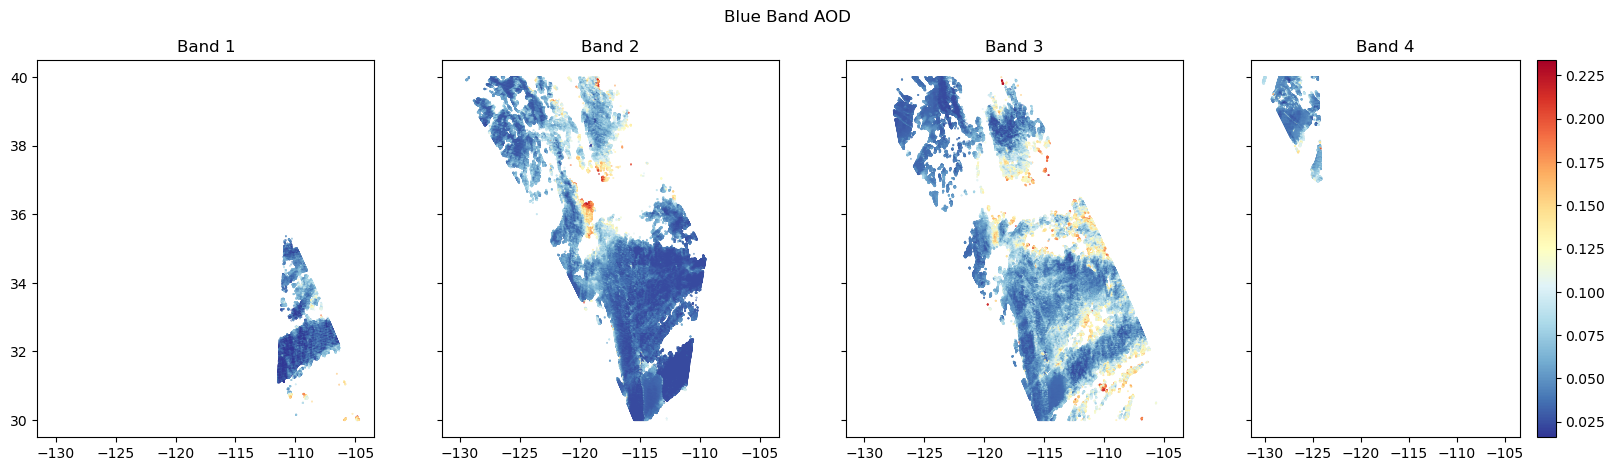

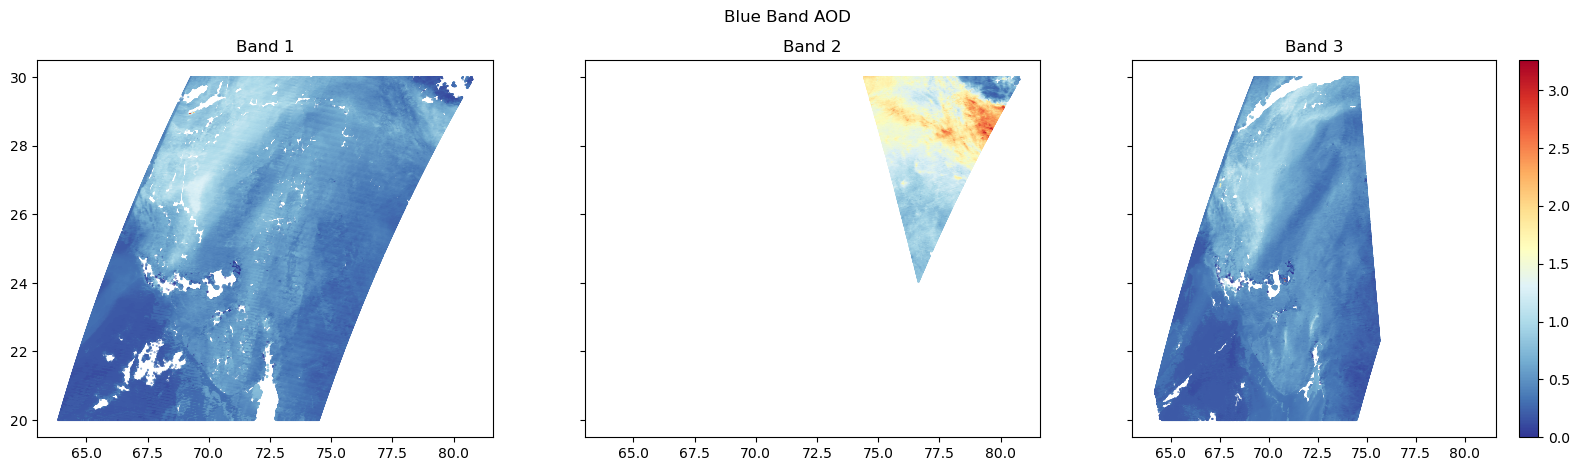

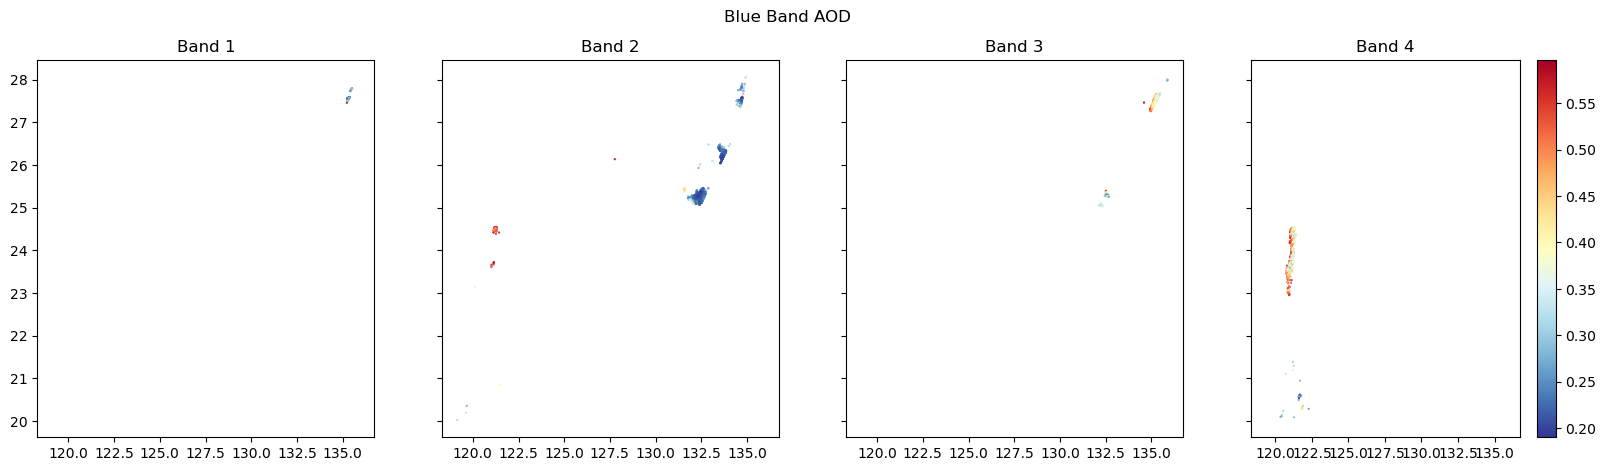

In [35]:
# Plot each orbit individually
plot_gdf(gdf1, separate_bands=True)

plot_gdf(gdf1_dl, separate_bands=True)

plot_gdf(gdf1_tpe, separate_bands=True)

### Prepare training data from all 3 locations

In [36]:
# Identify LA granule filepaths and grid cells
temp_maiac_md = maiac_md #save for next cells

maiac_md = maiac_md[maiac_md.location == "la"]

#changed code to access internally saved files
la_fp = []
for i in range(maiac_md.shape[0]):
    la_fp.append(str(maiac_md.iloc[i]['split']) + "/" + str(maiac_md.iloc[i]['product']) + "/" + str(maiac_md.iloc[i]['time_start'].year) + "/" + str(maiac_md.iloc[i].name))
print(len(la_fp))
la_gc = grid_md[grid_md.location == "Los Angeles (SoCAB)"].copy()

# Load training labels
train_labels = pd.read_csv(RAW / "train_labels.csv", parse_dates=["datetime"])
train_labels.rename(columns={"value": "pm25"}, inplace=True)

# Confirm all LA grid cells are in our training labels
assert la_gc.index.isin(train_labels.grid_id).all()

len(la_gc)

1065


14

In [37]:
# Identify all granule filepaths and grid cells
maiac_md = temp_maiac_md[temp_maiac_md.location == "dl"]

#changed code to access internally saved files
dl_fp = []
for i in range(maiac_md.shape[0]):
    dl_fp.append(str(maiac_md.iloc[i]['split']) + "/" + str(maiac_md.iloc[i]['product']) + "/" + str(maiac_md.iloc[i]['time_start'].year) + "/" + str(maiac_md.iloc[i].name))
print(len(dl_fp))
dl_gc = grid_md[grid_md.location == "Delhi"].copy()

# Load training labels
train_labels_dl = pd.read_csv(RAW / "train_labels.csv", parse_dates=["datetime"])
train_labels_dl.rename(columns={"value": "pm25"}, inplace=True)

# Confirm all LA grid cells are in our training labels
assert dl_gc.index.isin(train_labels.grid_id).all()

len(dl_gc)

1065


33

In [38]:
# Identify all granule filepaths and grid cells
maiac_md = temp_maiac_md[temp_maiac_md.location == "tpe"]

#changed code to access internally saved files
tpe_fp = []
for i in range(maiac_md.shape[0]):
    tpe_fp.append(str(maiac_md.iloc[i]['split']) + "/" + str(maiac_md.iloc[i]['product']) + "/" + str(maiac_md.iloc[i]['time_start'].year) + "/" + str(maiac_md.iloc[i].name))
print(len(tpe_fp))
tpe_gc = grid_md[grid_md.location == "Taipei"].copy()

# Load training labels
train_labels_tpe = pd.read_csv(RAW / "train_labels.csv", parse_dates=["datetime"])
train_labels_tpe.rename(columns={"value": "pm25"}, inplace=True)

# Confirm all LA grid cells are in our training labels
assert tpe_gc.index.isin(train_labels.grid_id).all()

len(tpe_gc)

2130


7

### Use geopandas to visualize the grid cell locations

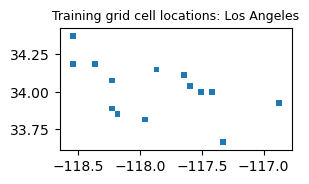

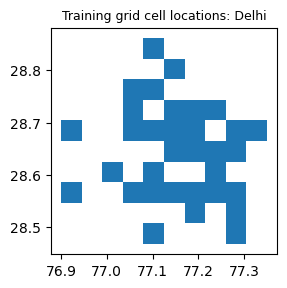

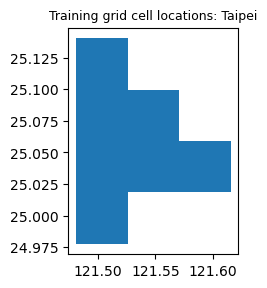

In [39]:
la_polys = gpd.GeoSeries.from_wkt(la_gc.wkt, crs=wgs84_crs) # used for WGS 84
la_polys.name = "geometry"
la_polys_gdf = gpd.GeoDataFrame(la_polys)

la_polys_gdf.plot(figsize=(3, 3)).set_title("Training grid cell locations: Los Angeles", fontsize=9);

dl_polys = gpd.GeoSeries.from_wkt(dl_gc.wkt, crs=wgs84_crs_dl) # used for WGS 84
dl_polys.name = "geometry"
dl_polys_gdf = gpd.GeoDataFrame(dl_polys)

dl_polys_gdf.plot(figsize=(3, 3)).set_title("Training grid cell locations: Delhi", fontsize=9);

tpe_polys = gpd.GeoSeries.from_wkt(tpe_gc.wkt, crs=wgs84_crs_tpe) # used for WGS 84
tpe_polys.name = "geometry"
tpe_polys_gdf = gpd.GeoDataFrame(tpe_polys)

tpe_polys_gdf.plot(figsize=(3, 3)).set_title("Training grid cell locations: Taipei", fontsize=9);

### Use the total_bounds attribute of our grid cell GeoDataFrame as a bounding box
By removing these points, we dramatically speed up the spatial join

In [40]:
xmin, ymin, xmax, ymax = la_polys_gdf.total_bounds
gpd.sjoin(la_polys_gdf, gdf1.cx[xmin:xmax, ymin:ymax], how="inner").groupby("grid_id")["value"].mean()
gpd.sjoin(la_polys_gdf, gdf2.cx[xmin:xmax, ymin:ymax], how="inner").groupby("grid_id")["value"].mean()

xmin_dl, ymin_dl, xmax_dl, ymax_dl = dl_polys_gdf.total_bounds
gpd.sjoin(dl_polys_gdf, gdf1_dl.cx[xmin_dl:xmax_dl, ymin_dl:ymax_dl], how="inner").groupby("grid_id")["value"].mean()
gpd.sjoin(dl_polys_gdf, gdf2_dl.cx[xmin_dl:xmax_dl, ymin_dl:ymax_dl], how="inner").groupby("grid_id")["value"].mean()

xmin_tpe, ymin_tpe, xmax_tpe, ymax_tpe = tpe_polys_gdf.total_bounds #tpe data may have issue, no data near training grids
gpd.sjoin(tpe_polys_gdf, gdf1_tpe.cx[xmin_tpe:xmax_tpe, ymin_tpe:ymax_tpe], how="inner").groupby("grid_id")["value"].mean()
gpd.sjoin(tpe_polys_gdf, gdf2_tpe.cx[xmin_tpe:xmax_tpe, ymin_tpe:ymax_tpe], how="inner").groupby("grid_id")["value"].mean()

Series([], Name: value, dtype: float64)

### Helper functions

In [41]:
def create_calibration_dict(data: SDS):
    """Define calibration dictionary given a SDS dataset,
    which contains:
        - name
        - scale factor
        - offset
        - unit
        - fill value
        - valid range
    
    Args:
        data (SDS): dataset in the SDS format.
    
    Returns:
        calibration_dict (Dict): dict of calibration parameters.
    """
    return data.attributes()


def create_alignment_dict(hdf: SD):
    """Define alignment dictionary given a SD data file, 
    which contains:
        - upper left coordinates
        - lower right coordinates
        - coordinate reference system (CRS)
        - CRS parameters
    
    Args:
        hdf (SD): hdf data object
    
    Returns:
        alignment_dict (Dict): dict of alignment parameters.
    """
    group_1 = hdf.attributes()["StructMetadata.0"].split("END_GROUP=GRID_1")[0]
    hdf_metadata = dict([x.split("=") for x in group_1.split() if "=" in x])
    alignment_dict = {
        "upper_left": eval(hdf_metadata["UpperLeftPointMtrs"]),
        "lower_right": eval(hdf_metadata["LowerRightMtrs"]),
        "crs": hdf_metadata["Projection"],
        "crs_params": hdf_metadata["ProjParams"]
    }
    return alignment_dict

### create a GDF of each intersecting point and the accompanying dataset value

In [42]:
def preprocess_maiac_data(
    granule_path: str,
    grid_cell_gdf: gpd.GeoDataFrame,
    dataset_name: str,
    total_bounds: np.ndarray = None
):
    """
    Given a granule s3 path and competition grid cells, 
    create a GDF of each intersecting point and the accompanying
    dataset value (e.g. blue band AOD).
    
    Args:
        granule_path (str): a path to a granule on s3.
        grid_cell_gdf (gpd.GeoDataFrame): GeoDataFrame that contains,
            at a minimum, a `grid_id` and `geometry` column of Polygons.
        dataset_name (str): specific dataset name (e.g. "Optical_Depth_047").
        total_bounds (np.ndarray, optional): If provided, will filter out points that fall
            outside of these bounds. Composed of xmin, ymin, xmax, ymax.    
    Returns:
        GeoDataFrame that contains Points and associated values.
    """
    
    hdf = SD(granule_path, SDC.READ)
    aod = hdf.select(dataset_name)
    shape = aod.info()[2]
    head, tail = os.path.split(granule_path)

    # Calibrate and align data
    calibration_dict = aod.attributes()
    alignment_dict = create_alignment_dict(hdf)
    corrected_AOD = calibrate_data(aod, shape, calibration_dict)
    xv, yv = create_meshgrid(alignment_dict, shape)
    lon, lat = transform_arrays(xv, yv, sinu_crs, wgs84_crs)

    # Save values that align with granules
    granule_gdf = convert_array_to_df(
        corrected_AOD,
        lat,
        lon,
        tail,
        wgs84_crs,
        grid_cell_gdf.total_bounds
    )
    df = gpd.sjoin(grid_cell_gdf, granule_gdf, how="inner")
    
    # Clean up files
    return df.drop(columns="index_right").reset_index()

'''  
def preprocess_aod_47(granule_paths, grid_cell_gdf, n_jobs=2):
    """
    Given a set of granule s3 paths and competition grid cells, 
    parallelizes creation of GDFs containing AOD 0.47 µm values and points.
    
    Args:
        granule_paths (List): list of paths on s3.
        grid_cell_gdf (gpd.GeoDataFrame): GeoDataFrame that contains,
            at a minimum, a `grid_id` and `geometry` column of Polygons.
        n_jobs (int, Optional): The number of parallel processes. Defaults to 2.
    
    Returns:
        GeoDataFrame that contains Points and associated values for all granules.
    """
    #print(granule_paths)
    args = ((gp, grid_cell_gdf, "Optical_Depth_047") for gp in granule_paths)
    #print(granule_paths)
    results = pqdm(args, preprocess_maiac_data, n_jobs=n_jobs, argument_type="args")
    #print(results)
    return pd.concat(results)
'''

'  \ndef preprocess_aod_47(granule_paths, grid_cell_gdf, n_jobs=2):\n    """\n    Given a set of granule s3 paths and competition grid cells, \n    parallelizes creation of GDFs containing AOD 0.47 µm values and points.\n    \n    Args:\n        granule_paths (List): list of paths on s3.\n        grid_cell_gdf (gpd.GeoDataFrame): GeoDataFrame that contains,\n            at a minimum, a `grid_id` and `geometry` column of Polygons.\n        n_jobs (int, Optional): The number of parallel processes. Defaults to 2.\n    \n    Returns:\n        GeoDataFrame that contains Points and associated values for all granules.\n    """\n    #print(granule_paths)\n    args = ((gp, grid_cell_gdf, "Optical_Depth_047") for gp in granule_paths)\n    #print(granule_paths)\n    results = pqdm(args, preprocess_maiac_data, n_jobs=n_jobs, argument_type="args")\n    #print(results)\n    return pd.concat(results)\n'

# This preprocesses all training data for all locations
We generate a csv file for each feature containing the relevant data from all grids. This step takes about 12 hours to complete, and only needs to be done once.

In [ ]:
#This takes about 12 hours, only need to run once and load from csv files instead

frames1 = []
frames2 = []
frames3 = []
frames4 = []
frames5 = []
frames6 = []
frames7 = []
frames8 = []
frames9 = []
frames10 = []
frames11 = []
frames12 = []
frames13 = []

loc_dfs1_all = []
loc_dfs2_all = []
loc_dfs3_all = []
loc_dfs4_all = []
loc_dfs5_all = []
loc_dfs6_all = []
loc_dfs7_all = []
loc_dfs8_all = []
loc_dfs9_all = []
loc_dfs10_all = []
loc_dfs11_all = []
loc_dfs12_all = []
loc_dfs13_all = []

#LA***********************************************************************************************
print(len(la_fp)) #the total number of iterations
for i in range(len(la_fp)): #this step takes a long time to run
#for i in range(3):
    print(i) #print current iteration
    la_train_gdf1 = pd.DataFrame(preprocess_maiac_data(la_fp[i], la_polys_gdf, "Optical_Depth_047"))
    la_train_gdf2 = pd.DataFrame(preprocess_maiac_data(la_fp[i], la_polys_gdf, "Optical_Depth_055"))
    la_train_gdf3 = pd.DataFrame(preprocess_maiac_data(la_fp[i], la_polys_gdf, "AOD_Uncertainty"))
    la_train_gdf4 = pd.DataFrame(preprocess_maiac_data(la_fp[i], la_polys_gdf, "FineModeFraction"))
    la_train_gdf5 = pd.DataFrame(preprocess_maiac_data(la_fp[i], la_polys_gdf, "Column_WV"))
    la_train_gdf6 = pd.DataFrame(preprocess_maiac_data(la_fp[i], la_polys_gdf, "AOD_QA"))
    la_train_gdf7 = pd.DataFrame(preprocess_maiac_data(la_fp[i], la_polys_gdf, "AOD_MODEL"))
    la_train_gdf8 = pd.DataFrame(preprocess_maiac_data(la_fp[i], la_polys_gdf, "Injection_Height"))
    la_train_gdf9 = pd.DataFrame(preprocess_maiac_data(la_fp[i], la_polys_gdf, "cosSZA"))
    la_train_gdf10 = pd.DataFrame(preprocess_maiac_data(la_fp[i], la_polys_gdf, "cosVZA"))
    la_train_gdf11 = pd.DataFrame(preprocess_maiac_data(la_fp[i], la_polys_gdf, "RelAZ"))
    la_train_gdf12 = pd.DataFrame(preprocess_maiac_data(la_fp[i], la_polys_gdf, "Scattering_Angle"))
    la_train_gdf13 = pd.DataFrame(preprocess_maiac_data(la_fp[i], la_polys_gdf, "Glint_Angle"))
    frames1.append(la_train_gdf1)
    frames2.append(la_train_gdf2)
    frames3.append(la_train_gdf3)
    frames4.append(la_train_gdf4)
    frames5.append(la_train_gdf5)
    frames6.append(la_train_gdf6)
    frames7.append(la_train_gdf7)
    frames8.append(la_train_gdf8)
    frames9.append(la_train_gdf9)
    frames10.append(la_train_gdf10)
    frames11.append(la_train_gdf11)
    frames12.append(la_train_gdf12)
    frames13.append(la_train_gdf13)

la_train_gdf1 = pd.concat(frames1)
la_train_gdf2 = pd.concat(frames2)
la_train_gdf3 = pd.concat(frames3)
la_train_gdf4 = pd.concat(frames4)
la_train_gdf5 = pd.concat(frames5)
la_train_gdf6 = pd.concat(frames6)
la_train_gdf7 = pd.concat(frames7)
la_train_gdf8 = pd.concat(frames8)
la_train_gdf9 = pd.concat(frames9)
la_train_gdf10 = pd.concat(frames10)
la_train_gdf11 = pd.concat(frames11)
la_train_gdf12 = pd.concat(frames12)
la_train_gdf13 = pd.concat(frames13)

loc_dfs1_all.append(la_train_gdf1)
loc_dfs2_all.append(la_train_gdf2)
loc_dfs3_all.append(la_train_gdf3)
loc_dfs4_all.append(la_train_gdf4)
loc_dfs5_all.append(la_train_gdf5)
loc_dfs6_all.append(la_train_gdf6)
loc_dfs7_all.append(la_train_gdf7)
loc_dfs8_all.append(la_train_gdf8)
loc_dfs9_all.append(la_train_gdf9)
loc_dfs10_all.append(la_train_gdf10)
loc_dfs11_all.append(la_train_gdf11)
loc_dfs12_all.append(la_train_gdf12)
loc_dfs13_all.append(la_train_gdf13)

frames1 = []
frames2 = []
frames3 = []
frames4 = []
frames5 = []
frames6 = []
frames7 = []
frames8 = []
frames9 = []
frames10 = []
frames11 = []
frames12 = []
frames13 = []

#DL**************************************************************************************************
print(len(dl_fp)) #the total number of iterations
for i in range(len(dl_fp)): #this step takes a long time to run
#for i in range(3):
    print(i) #print current iteration
    dl_train_gdf1 = pd.DataFrame(preprocess_maiac_data(dl_fp[i], dl_polys_gdf, "Optical_Depth_047"))
    dl_train_gdf2 = pd.DataFrame(preprocess_maiac_data(dl_fp[i], dl_polys_gdf, "Optical_Depth_055"))
    dl_train_gdf3 = pd.DataFrame(preprocess_maiac_data(dl_fp[i], dl_polys_gdf, "AOD_Uncertainty"))
    dl_train_gdf4 = pd.DataFrame(preprocess_maiac_data(dl_fp[i], dl_polys_gdf, "FineModeFraction"))
    dl_train_gdf5 = pd.DataFrame(preprocess_maiac_data(dl_fp[i], dl_polys_gdf, "Column_WV"))
    dl_train_gdf6 = pd.DataFrame(preprocess_maiac_data(dl_fp[i], dl_polys_gdf, "AOD_QA"))
    dl_train_gdf7 = pd.DataFrame(preprocess_maiac_data(dl_fp[i], dl_polys_gdf, "AOD_MODEL"))
    dl_train_gdf8 = pd.DataFrame(preprocess_maiac_data(dl_fp[i], dl_polys_gdf, "Injection_Height"))
    dl_train_gdf9 = pd.DataFrame(preprocess_maiac_data(dl_fp[i], dl_polys_gdf, "cosSZA"))
    dl_train_gdf10 = pd.DataFrame(preprocess_maiac_data(dl_fp[i], dl_polys_gdf, "cosVZA"))
    dl_train_gdf11 = pd.DataFrame(preprocess_maiac_data(dl_fp[i], dl_polys_gdf, "RelAZ"))
    dl_train_gdf12 = pd.DataFrame(preprocess_maiac_data(dl_fp[i], dl_polys_gdf, "Scattering_Angle"))
    dl_train_gdf13 = pd.DataFrame(preprocess_maiac_data(dl_fp[i], dl_polys_gdf, "Glint_Angle"))
    frames1.append(dl_train_gdf1)
    frames2.append(dl_train_gdf2)
    frames3.append(dl_train_gdf3)
    frames4.append(dl_train_gdf4)
    frames5.append(dl_train_gdf5)
    frames6.append(dl_train_gdf6)
    frames7.append(dl_train_gdf7)
    frames8.append(dl_train_gdf8)
    frames9.append(dl_train_gdf9)
    frames10.append(dl_train_gdf10)
    frames11.append(dl_train_gdf11)
    frames12.append(dl_train_gdf12)
    frames13.append(dl_train_gdf13)

dl_train_gdf1 = pd.concat(frames1)
dl_train_gdf2 = pd.concat(frames2)
dl_train_gdf3 = pd.concat(frames3)
dl_train_gdf4 = pd.concat(frames4)
dl_train_gdf5 = pd.concat(frames5)
dl_train_gdf6 = pd.concat(frames6)
dl_train_gdf7 = pd.concat(frames7)
dl_train_gdf8 = pd.concat(frames8)
dl_train_gdf9 = pd.concat(frames9)
dl_train_gdf10 = pd.concat(frames10)
dl_train_gdf11 = pd.concat(frames11)
dl_train_gdf12 = pd.concat(frames12)
dl_train_gdf13 = pd.concat(frames13)

loc_dfs1_all.append(dl_train_gdf1)
loc_dfs2_all.append(dl_train_gdf2)
loc_dfs3_all.append(dl_train_gdf3)
loc_dfs4_all.append(dl_train_gdf4)
loc_dfs5_all.append(dl_train_gdf5)
loc_dfs6_all.append(dl_train_gdf6)
loc_dfs7_all.append(dl_train_gdf7)
loc_dfs8_all.append(dl_train_gdf8)
loc_dfs9_all.append(dl_train_gdf9)
loc_dfs10_all.append(dl_train_gdf10)
loc_dfs11_all.append(dl_train_gdf11)
loc_dfs12_all.append(dl_train_gdf12)
loc_dfs13_all.append(dl_train_gdf13)

frames1 = []
frames2 = []
frames3 = []
frames4 = []
frames5 = []
frames6 = []
frames7 = []
frames8 = []
frames9 = []
frames10 = []
frames11 = []
frames12 = []
frames13 = []

#TPE**************************************************************************************************
print(len(tpe_fp)) #the total number of iterations
for i in range(len(tpe_fp)): #this step takes about 35 minutes to run
#for i in range(3):
    print(i) #print current iteration
    tpe_train_gdf1 = pd.DataFrame(preprocess_maiac_data(tpe_fp[i], tpe_polys_gdf, "Optical_Depth_047"))
    tpe_train_gdf2 = pd.DataFrame(preprocess_maiac_data(tpe_fp[i], tpe_polys_gdf, "Optical_Depth_055"))
    tpe_train_gdf3 = pd.DataFrame(preprocess_maiac_data(tpe_fp[i], tpe_polys_gdf, "AOD_Uncertainty"))
    tpe_train_gdf4 = pd.DataFrame(preprocess_maiac_data(tpe_fp[i], tpe_polys_gdf, "FineModeFraction"))
    tpe_train_gdf5 = pd.DataFrame(preprocess_maiac_data(tpe_fp[i], tpe_polys_gdf, "Column_WV"))
    tpe_train_gdf6 = pd.DataFrame(preprocess_maiac_data(tpe_fp[i], tpe_polys_gdf, "AOD_QA"))
    tpe_train_gdf7 = pd.DataFrame(preprocess_maiac_data(tpe_fp[i], tpe_polys_gdf, "AOD_MODEL"))
    tpe_train_gdf8 = pd.DataFrame(preprocess_maiac_data(tpe_fp[i], tpe_polys_gdf, "Injection_Height"))
    tpe_train_gdf9 = pd.DataFrame(preprocess_maiac_data(tpe_fp[i], tpe_polys_gdf, "cosSZA"))
    tpe_train_gdf10 = pd.DataFrame(preprocess_maiac_data(tpe_fp[i], tpe_polys_gdf, "cosVZA"))
    tpe_train_gdf11 = pd.DataFrame(preprocess_maiac_data(tpe_fp[i], tpe_polys_gdf, "RelAZ"))
    tpe_train_gdf12 = pd.DataFrame(preprocess_maiac_data(tpe_fp[i], tpe_polys_gdf, "Scattering_Angle"))
    tpe_train_gdf13 = pd.DataFrame(preprocess_maiac_data(tpe_fp[i], tpe_polys_gdf, "Glint_Angle"))
    frames1.append(tpe_train_gdf1)
    frames2.append(tpe_train_gdf2)
    frames3.append(tpe_train_gdf3)
    frames4.append(tpe_train_gdf4)
    frames5.append(tpe_train_gdf5)
    frames6.append(tpe_train_gdf6)
    frames7.append(tpe_train_gdf7)
    frames8.append(tpe_train_gdf8)
    frames9.append(tpe_train_gdf9)
    frames10.append(tpe_train_gdf10)
    frames11.append(tpe_train_gdf11)
    frames12.append(tpe_train_gdf12)
    frames13.append(tpe_train_gdf13)

tpe_train_gdf1 = pd.concat(frames1)
tpe_train_gdf2 = pd.concat(frames2)
tpe_train_gdf3 = pd.concat(frames3)
tpe_train_gdf4 = pd.concat(frames4)
tpe_train_gdf5 = pd.concat(frames5)
tpe_train_gdf6 = pd.concat(frames6)
tpe_train_gdf7 = pd.concat(frames7)
tpe_train_gdf8 = pd.concat(frames8)
tpe_train_gdf9 = pd.concat(frames9)
tpe_train_gdf10 = pd.concat(frames10)
tpe_train_gdf11 = pd.concat(frames11)
tpe_train_gdf12 = pd.concat(frames12)
tpe_train_gdf13 = pd.concat(frames13)

loc_dfs1_all.append(tpe_train_gdf1)
loc_dfs2_all.append(tpe_train_gdf2)
loc_dfs3_all.append(tpe_train_gdf3)
loc_dfs4_all.append(tpe_train_gdf4)
loc_dfs5_all.append(tpe_train_gdf5)
loc_dfs6_all.append(tpe_train_gdf6)
loc_dfs7_all.append(tpe_train_gdf7)
loc_dfs8_all.append(tpe_train_gdf8)
loc_dfs9_all.append(tpe_train_gdf9)
loc_dfs10_all.append(tpe_train_gdf10)
loc_dfs11_all.append(tpe_train_gdf11)
loc_dfs12_all.append(tpe_train_gdf12)
loc_dfs13_all.append(tpe_train_gdf13)

test_df1_all = pd.concat(loc_dfs1_all)
test_df2_all = pd.concat(loc_dfs2_all)
test_df3_all = pd.concat(loc_dfs3_all)
test_df4_all = pd.concat(loc_dfs4_all)
test_df5_all = pd.concat(loc_dfs5_all)
test_df6_all = pd.concat(loc_dfs6_all)
test_df7_all = pd.concat(loc_dfs7_all)
test_df8_all = pd.concat(loc_dfs8_all)
test_df9_all = pd.concat(loc_dfs9_all)
test_df10_all = pd.concat(loc_dfs10_all)
test_df11_all = pd.concat(loc_dfs11_all)
test_df12_all = pd.concat(loc_dfs12_all)
test_df13_all = pd.concat(loc_dfs13_all)

#this saves the results to load later
'''
filepath1 = 'data/train1.csv' 
test_df1_all.to_csv(filepath1, index=False)
filepath2 = 'data/train2.csv' 
test_df2_all.to_csv(filepath2, index=False) 
filepath3 = 'data/train3.csv' 
test_df3_all.to_csv(filepath3, index=False)
filepath4 = 'data/train4.csv' 
test_df4_all.to_csv(filepath4, index=False)
filepath5 = 'data/train5.csv' 
test_df5_all.to_csv(filepath5, index=False)
filepath6 = 'data/train6.csv' 
test_df6_all.to_csv(filepath6, index=False)
filepath7 = 'data/train7.csv' 
test_df7_all.to_csv(filepath7, index=False)
filepath8 = 'data/train8.csv' 
test_df8_all.to_csv(filepath8, index=False)
filepath9 = 'data/train9.csv' 
test_df9_all.to_csv(filepath9, index=False)
filepath10 = 'data/train10.csv' 
test_df10_all.to_csv(filepath10, index=False)
filepath11 = 'data/train11.csv' 
test_df11_all.to_csv(filepath11, index=False)
filepath12 = 'data/train12.csv' 
test_df12_all.to_csv(filepath12, index=False)
filepath13 = 'data/train13.csv' 
test_df13_all.to_csv(filepath13, index=False)
'''

### Load the preprocessed data from csv

In [43]:
#read data from saved csv files
#df_empty = pd.DataFrame({'grid_id' : [], 'geometry' : [], 'granule_id' : [], 'orbit' : [], 'value' : []})
filepath1 = 'data/train1.csv' 
test_df1_all = pd.read_csv(filepath1)
filepath2 = 'data/train2.csv' 
test_df2_all = pd.read_csv(filepath2)
filepath3 = 'data/train3.csv' 
test_df3_all = pd.read_csv(filepath3)
filepath4 = 'data/train4.csv' 
test_df4_all = pd.read_csv(filepath4)
filepath5 = 'data/train5.csv' 
test_df5_all = pd.read_csv(filepath5)
filepath6 = 'data/train6.csv' 
test_df6_all = pd.read_csv(filepath6)
filepath7 = 'data/train7.csv' 
test_df7_all = pd.read_csv(filepath7)
filepath8 = 'data/train8.csv' 
test_df8_all = pd.read_csv(filepath8)
filepath9 = 'data/train9.csv' 
test_df9_all = pd.read_csv(filepath9)
filepath10 = 'data/train10.csv' 
test_df10_all = pd.read_csv(filepath10)
filepath11 = 'data/train11.csv' 
test_df11_all = pd.read_csv(filepath11)
filepath12 = 'data/train12.csv' 
test_df12_all = pd.read_csv(filepath12)
filepath13 = 'data/train13.csv' 
test_df13_all = pd.read_csv(filepath13)

### print the shape of all preprocessed data
We can see that feature 4 is not in the correct format, and should be omitted

In [44]:
la_train_gdf1 = test_df1_all
la_train_gdf2 = test_df2_all
la_train_gdf3 = test_df3_all
la_train_gdf4 = test_df4_all
la_train_gdf5 = test_df5_all
la_train_gdf6 = test_df6_all
la_train_gdf7 = test_df7_all
la_train_gdf8 = test_df8_all
la_train_gdf9 = test_df9_all
la_train_gdf10 = test_df10_all
la_train_gdf11 = test_df11_all
la_train_gdf12 = test_df12_all
la_train_gdf13 = test_df13_all

print(la_train_gdf1.shape)
print(la_train_gdf2.shape)
print(la_train_gdf3.shape)
print(la_train_gdf4.shape)
print(la_train_gdf5.shape)
print(la_train_gdf6.shape)
print(la_train_gdf7.shape)
print(la_train_gdf8.shape)
print(la_train_gdf9.shape)
print(la_train_gdf10.shape)
print(la_train_gdf11.shape)
print(la_train_gdf12.shape)
print(la_train_gdf13.shape)

(1110070, 5)
(1108952, 5)
(2534203, 5)
(0, 5)
(2484059, 5)
(3077784, 5)
(1108952, 5)
(74320, 5)
(91353, 5)
(91353, 5)
(91353, 5)
(91353, 5)
(91353, 5)


### This calculated the mean, min, and max of a feature for each grid + datetime combination

In [45]:
#simple benchmark model
def calculate_features(
    feature_df: gpd.GeoDataFrame,
    label_df: pd.DataFrame,
    stage: str,
):
    """Given processed AOD data and training labels (train) or 
    submission format (test), return a feature GeoDataFrame that contains
    features for mean, max, and min AOD.
    
    Args:
        feature_df (gpd.GeoDataFrame): GeoDataFrame that contains
            Points and associated values.
        label_df (pd.DataFrame): training labels (train) or
            submission format (test).
        stage (str): "train" or "test".
    
    Returns:
        full_data (gpd.GeoDataFrame): GeoDataFrame that contains `mean_aod`,
            `max_aod`, and `min_aod` for each grid cell and datetime.   
    """
    # Add `day` column to `feature_df` and `label_df`
    feature_df["datetime"] = pd.to_datetime(
        feature_df.granule_id.str.split("_", expand=True)[0],
        format="%Y%m%dT%H:%M:%S",
        utc=True
    )
    feature_df["day"] = feature_df.datetime.dt.date
    label_df["day"] = label_df.datetime.dt.date
    
    # Calculate average AOD per day/grid cell for which we have feature data
    avg_aod_day = feature_df.groupby(["day", "grid_id"]).agg(
        {"value": ["mean", "min", "max"]}
    )
    avg_aod_day.columns = ["mean_aod", "min_aod", "max_aod"]
    avg_aod_day = avg_aod_day.reset_index()

    # Join labels/submission format with feature data
    how = "inner" if stage == "train" else "left"
    full_data = pd.merge(
        label_df,
        avg_aod_day,
        how=how,
        left_on=["day", "grid_id"],
        right_on=["day", "grid_id"]
    )
    return full_data

### calculate features from the preprocessed csv data
Note that we will omit feature 4 which is not in the correct format, and feature 8 which contains only 2621 useable data, compared to 20,000+ in others

In [46]:
full_data1 = calculate_features(la_train_gdf1, train_labels, stage="train")
full_data2 = calculate_features(la_train_gdf2, train_labels, stage="train")
full_data3 = calculate_features(la_train_gdf3, train_labels, stage="train")
#full_data4 = calculate_features(la_train_gdf4, train_labels, stage="train") #do not use, no useable data
full_data5 = calculate_features(la_train_gdf5, train_labels, stage="train")
full_data6 = calculate_features(la_train_gdf6, train_labels, stage="train")
full_data7 = calculate_features(la_train_gdf7, train_labels, stage="train")
full_data8 = calculate_features(la_train_gdf8, train_labels, stage="train") 
full_data9 = calculate_features(la_train_gdf9, train_labels, stage="train")
full_data10 = calculate_features(la_train_gdf10, train_labels, stage="train")
full_data11 = calculate_features(la_train_gdf11, train_labels, stage="train")
full_data12 = calculate_features(la_train_gdf12, train_labels, stage="train")
full_data13 = calculate_features(la_train_gdf13, train_labels, stage="train")

print(full_data1.shape)
print(full_data2.shape)
print(full_data3.shape)
#print(full_data4.shape)
print(full_data5.shape)
print(full_data6.shape)
print(full_data7.shape)
print(full_data8.shape) #do not use, only 2621 useable data, vs 20,000+ in others
print(full_data9.shape)
print(full_data10.shape)
print(full_data11.shape)
print(full_data12.shape)
print(full_data13.shape)

(20567, 7)
(20565, 7)
(34289, 7)
(34215, 7)
(34312, 7)
(20565, 7)
(2621, 7)
(27639, 7)
(27639, 7)
(27639, 7)
(27639, 7)
(27639, 7)


### Rename the columns, and merge into a single datastructure
We rename the columns for each feature, and perform an inner join to grow the data output. We print the data size between each join to better understand. Each join adds the mean, max, and min of the next feature which is why the size grows by 3 with each join.

Note: features 1, 2, 3, 5, 6, and 7 contain 20565 data points, and features 9, 10, 11, 12, 13 contain 16276 data points. Although we lose ~4000 data points by merging in this way, we determined that it is better to gain the 5 extra features.

In [47]:
#rename columns for non-duplicate merging
renamed1 = full_data1
renamed1 = renamed1.rename(columns={"mean_aod": "mean1", "min_aod": "min1", "max_aod": "max1"})
renamed2 = full_data2
renamed2 = renamed2.rename(columns={"mean_aod": "mean2", "min_aod": "min2", "max_aod": "max2"})
renamed3 = full_data3
renamed3 = renamed3.rename(columns={"mean_aod": "mean3", "min_aod": "min3", "max_aod": "max3"})
renamed5 = full_data5
renamed5 = renamed5.rename(columns={"mean_aod": "mean5", "min_aod": "min5", "max_aod": "max5"})
renamed6 = full_data6
renamed6 = renamed6.rename(columns={"mean_aod": "mean6", "min_aod": "min6", "max_aod": "max6"})
renamed7 = full_data7
renamed7 = renamed7.rename(columns={"mean_aod": "mean7", "min_aod": "min7", "max_aod": "max7"})
renamed9 = full_data9
renamed9 = renamed9.rename(columns={"mean_aod": "mean9", "min_aod": "min9", "max_aod": "max9"})
renamed10 = full_data10
renamed10 = renamed10.rename(columns={"mean_aod": "mean10", "min_aod": "min10", "max_aod": "max10"})
renamed11 = full_data11
renamed11 = renamed11.rename(columns={"mean_aod": "mean11", "min_aod": "min11", "max_aod": "max11"})
renamed12 = full_data12
renamed12 = renamed12.rename(columns={"mean_aod": "mean12", "min_aod": "min12", "max_aod": "max12"})
renamed13 = full_data13
renamed13 = renamed13.rename(columns={"mean_aod": "mean13", "min_aod": "min13", "max_aod": "max13"})

#merging all data into a single datastructure
full_data = pd.merge(renamed1, renamed2,  how='inner', left_on=['datetime','grid_id', 'pm25', 'day'], right_on = ['datetime','grid_id', 'pm25', 'day'])
print(full_data.shape)
full_data = pd.merge(full_data, renamed3,  how='inner', left_on=['datetime','grid_id', 'pm25', 'day'], right_on = ['datetime','grid_id', 'pm25', 'day'])
print(full_data.shape)
#skip 4, no data
full_data = pd.merge(full_data, renamed5,  how='inner', left_on=['datetime','grid_id', 'pm25', 'day'], right_on = ['datetime','grid_id', 'pm25', 'day'])
print(full_data.shape)
full_data = pd.merge(full_data, renamed6,  how='inner', left_on=['datetime','grid_id', 'pm25', 'day'], right_on = ['datetime','grid_id', 'pm25', 'day'])
print(full_data.shape)
full_data = pd.merge(full_data, renamed7,  how='inner', left_on=['datetime','grid_id', 'pm25', 'day'], right_on = ['datetime','grid_id', 'pm25', 'day'])
print(full_data.shape)

#data 9-13 are only 16276 in length, potentially may be worth leaving out to have 20565 in length
full_data = pd.merge(full_data, renamed9,  how='inner', left_on=['datetime','grid_id', 'pm25', 'day'], right_on = ['datetime','grid_id', 'pm25', 'day'])
print(full_data.shape)
full_data = pd.merge(full_data, renamed10,  how='inner', left_on=['datetime','grid_id', 'pm25', 'day'], right_on = ['datetime','grid_id', 'pm25', 'day'])
print(full_data.shape)
full_data = pd.merge(full_data, renamed11,  how='inner', left_on=['datetime','grid_id', 'pm25', 'day'], right_on = ['datetime','grid_id', 'pm25', 'day'])
print(full_data.shape)
full_data = pd.merge(full_data, renamed12,  how='inner', left_on=['datetime','grid_id', 'pm25', 'day'], right_on = ['datetime','grid_id', 'pm25', 'day'])
print(full_data.shape)
full_data = pd.merge(full_data, renamed13,  how='inner', left_on=['datetime','grid_id', 'pm25', 'day'], right_on = ['datetime','grid_id', 'pm25', 'day'])
print(full_data.shape)

print(full_data.head(3))

(20565, 10)
(20565, 13)
(20565, 16)
(20565, 19)
(20565, 22)
(16276, 25)
(16276, 28)
(16276, 31)
(16276, 34)
(16276, 37)
                   datetime grid_id  pm25         day     mean1   min1   max1  \
0 2018-02-01 08:00:00+00:00   A2FBI  17.0  2018-02-01  0.081053  0.059  0.106   
1 2018-02-01 08:00:00+00:00   DJN0F  11.1  2018-02-01  0.077973  0.036  0.133   
2 2018-02-01 08:00:00+00:00   E5P9N  22.1  2018-02-01  0.102154  0.052  0.161   

      mean2   min2   max2  ...   max10  mean11  min11  max11   mean12   min12  \
0  0.059921  0.044  0.078  ...  0.7801  62.380  59.59  65.17  104.285  102.52   
1  0.057541  0.026  0.098  ...  0.7928  62.815  59.92  65.71  104.555  103.49   
2  0.075513  0.038  0.119  ...  0.7846  62.370  59.23  65.51  104.295  102.75   

    max12  mean13  min13  max13  
0  106.05  45.045  43.67  46.42  
1  105.62  45.415  43.85  46.98  
2  105.84  45.075  43.41  46.74  

[3 rows x 37 columns]


### Adding additional features
After merging all the data, we add a few additional features. These include the year, month, day, and hour. We also add the city location with 0 = LA, 1 = DL, and 2 = TPE. Finally, we added the lower left coordinate (x, y) of the grid.

The full data is displayed as output, which will be used for training and validating the models.

In [48]:
#Skyler added features: year, month, day, hour, location (0 = LA, 1 = DL, 2 = TPE)
full_data["y"] = full_data.datetime.dt.year
full_data["m"] = full_data.datetime.dt.month
full_data["d"] = full_data.datetime.dt.day
full_data["h"] = full_data.datetime.dt.hour

locs = []
for i in range(full_data.shape[0]):
    index = grid_md.index.tolist().index(full_data["grid_id"][i])
    location = grid_md.location.tolist()[index]
    if location == 'Los Angeles (SoCAB)':
        locs.append(0)
    if location == 'Delhi':
        locs.append(1)
    if location == 'Taipei':
        locs.append(2)

full_data["locs"] = locs

x_loc = [] #get coordinates of lower left corner
y_loc = []
for i in range(full_data.shape[0]):
    index = grid_md.index.tolist().index(full_data["grid_id"][i]) 
    x_new = float(grid_md.wkt.tolist()[index].split()[1][2:])
    x_loc.append(x_new)
    y_new = float(grid_md.wkt.tolist()[index].split()[2][:-1])
    y_loc.append(y_new)
    
full_data["x_loc"] = x_loc
full_data["y_loc"] = y_loc

full_data

,datetime,grid_id,pm25,day,mean1,min1,max1,mean2,min2,max2,...,mean13,min13,max13,y,m,d,h,locs,x_loc,y_loc
0,2018-02-01 08:00:00+00:00,A2FBI,17.000000,2018-02-01,0.081053,0.059,0.106,0.059921,0.044,0.078,...,45.045,43.67,46.42,2018,2,1,8,0,-117.394836,33.982011
1,2018-02-01 08:00:00+00:00,DJN0F,11.100000,2018-02-01,0.077973,0.036,0.133,0.057541,0.026,0.098,...,45.415,43.85,46.98,2018,2,1,8,0,-117.619414,34.093672
2,2018-02-01 08:00:00+00:00,E5P9N,22.100000,2018-02-01,0.102154,0.052,0.161,0.075513,0.038,0.119,...,45.075,43.41,46.74,2018,2,1,8,0,-117.484667,33.982011
3,2018-02-01 08:00:00+00:00,FRITQ,29.800000,2018-02-01,0.123091,0.093,0.163,0.090977,0.069,0.121,...,45.525,42.95,48.10,2018,2,1,8,0,-118.158404,33.832902
4,2018-02-01 08:00:00+00:00,H96P6,12.800000,2018-02-01,0.132739,0.109,0.166,0.098087,0.081,0.122,...,45.660,43.05,48.27,2018,2,1,8,0,-118.517730,34.168031
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16271,2020-12-31 18:30:00+00:00,90S79,390.566667,2020-12-31,1.873667,1.739,1.963,1.525111,1.416,1.598,...,81.115,66.62,95.61,2020,12,31,18,1,77.214700,28.625526
16272,2020-12-31 18:30:00+00:00,A7UCQ,268.850548,2020-12-31,1.742870,1.685,1.885,1.418522,1.371,1.534,...,80.615,66.30,94.93,2020,12,31,18,1,77.259616,28.586092
16273,2020-12-31 18:30:00+00:00,HANW9,399.463415,2020-12-31,1.746250,1.674,1.797,1.421250,1.363,1.462,...,81.005,66.43,95.58,2020,12,31,18,1,77.214700,28.546645
16274,2020-12-31 18:30:00+00:00,IUMEZ,529.604348,2020-12-31,1.954077,1.741,2.144,1.594538,1.417,1.756,...,80.920,66.80,95.04,2020,12,31,18,1,77.259616,28.625526


### We use data 2019 or earlier as the training set, and data after 2019 as the test set

In [49]:
# 2020 data will be held out for validation
train = full_data[full_data.datetime.dt.year <= 2019].copy()
test = full_data[full_data.datetime.dt.year > 2019].copy()

# Random Forest Regressor
We first use a random forest regressor as a baseline model

In [50]:
# Train model on train set
model = RandomForestRegressor()
model.fit(train[["mean1", "min1", "max1", "mean2", "min2", "max2", "mean3", "min3", "max3", "mean5", "min5", "max5", "mean6", "min6", "max6", "mean7", "min7", "max7", "mean9", "min9", "max9", "mean10", "min10", "max10", "mean11", "min11", "max11", "mean12", "min12", "max12", "mean13", "min13", "max13", "y", "m", "d", "h", "locs", "x_loc", "y_loc"]], train.pm25)

# Compute R2 using our holdout set
model.score(test[["mean1", "min1", "max1", "mean2", "min2", "max2", "mean3", "min3", "max3", "mean5", "min5", "max5", "mean6", "min6", "max6", "mean7", "min7", "max7", "mean9", "min9", "max9", "mean10", "min10", "max10", "mean11", "min11", "max11", "mean12", "min12", "max12", "mean13", "min13", "max13", "y", "m", "d", "h", "locs", "x_loc", "y_loc"]], test.pm25)

0.48650808272060364

### Refit the model on the entire training set

In [51]:
# Refit model on entire training set
model.fit(full_data[["mean1", "min1", "max1", "mean2", "min2", "max2", "mean3", "min3", "max3", "mean5", "min5", "max5", "mean6", "min6", "max6", "mean7", "min7", "max7", "mean9", "min9", "max9", "mean10", "min10", "max10", "mean11", "min11", "max11", "mean12", "min12", "max12", "mean13", "min13", "max13", "y", "m", "d", "h", "locs", "x_loc", "y_loc"]], full_data.pm25)


RandomForestRegressor()

### Open submission format

In [52]:
# Identify test granule s3 paths
test_md = pm_md[(pm_md["product"] == "maiac") & (pm_md["split"] == "test")]

# Identify test grid cells
submission_format = pd.read_csv(RAW / "submission_format.csv", parse_dates=["datetime"])
test_gc = grid_md[grid_md.index.isin(submission_format.grid_id)]

# Process test data for each location
locations = test_gc.location.unique()
loc_map = {"Delhi": "dl", "Los Angeles (SoCAB)": "la", "Taipei": "tpe"}

# This preprocesses all submission data for all locations
This step is the same as for the training data. We extract the same features from the submission data to use to predict the PM25 value.

In [ ]:
loc_dfs1 = []
loc_dfs2 = []
loc_dfs3 = []
loc_dfs4 = []
loc_dfs5 = []
loc_dfs6 = []
loc_dfs7 = []
loc_dfs8 = []
loc_dfs9 = []
loc_dfs10 = []
loc_dfs11 = []
loc_dfs12 = []
loc_dfs13 = []

for loc in locations:
    print(loc)
    these_md = test_md[test_md.location == loc_map[loc]]
    
    #changed code to access internally saved files
    these_fp = []
    for i in range(these_md.shape[0]):
        these_fp.append(str(these_md.iloc[i]['split']) + "/" + str(these_md.iloc[i]['product']) + "/" + str(these_md.iloc[i]['time_start'].year) + "/" + str(these_md.iloc[i].name))
    
    # Create grid cell GeoDataFrame
    these_grid_cells = test_gc[test_gc.location == loc]
    these_polys = gpd.GeoSeries.from_wkt(these_grid_cells.wkt, crs=wgs84_crs)
    these_polys.name = "geometry"
    this_polys_gdf = gpd.GeoDataFrame(these_polys)

    # Preprocess AOD for test granules
    
    #Skyler code replaces this
    #result = preprocess_aod_47(these_fp, this_polys_gdf)
    frames1 = []
    frames2 = []
    frames3 = []
    frames4 = []
    frames5 = []
    frames6 = []
    frames7 = []
    frames8 = []
    frames9 = []
    frames10 = []
    frames11 = []
    frames12 = []
    frames13 = []
    print(len(these_fp)) #the total number of iterations
    for i in range(len(these_fp)): #this step takes a long time
    #for i in range(3):
        print(i) #print current iteration
        train_gdf1 = pd.DataFrame(preprocess_maiac_data(these_fp[i], this_polys_gdf, "Optical_Depth_047"))
        train_gdf2 = pd.DataFrame(preprocess_maiac_data(these_fp[i], this_polys_gdf, "Optical_Depth_055"))
        train_gdf3 = pd.DataFrame(preprocess_maiac_data(these_fp[i], this_polys_gdf, "AOD_Uncertainty"))
        train_gdf4 = pd.DataFrame(preprocess_maiac_data(these_fp[i], this_polys_gdf, "FineModeFraction"))
        train_gdf5 = pd.DataFrame(preprocess_maiac_data(these_fp[i], this_polys_gdf, "Column_WV"))
        train_gdf6 = pd.DataFrame(preprocess_maiac_data(these_fp[i], this_polys_gdf, "AOD_QA"))
        train_gdf7 = pd.DataFrame(preprocess_maiac_data(these_fp[i], this_polys_gdf, "AOD_MODEL"))
        train_gdf8 = pd.DataFrame(preprocess_maiac_data(these_fp[i], this_polys_gdf, "Injection_Height"))
        train_gdf9 = pd.DataFrame(preprocess_maiac_data(these_fp[i], this_polys_gdf, "cosSZA"))
        train_gdf10 = pd.DataFrame(preprocess_maiac_data(these_fp[i], this_polys_gdf, "cosVZA"))
        train_gdf11 = pd.DataFrame(preprocess_maiac_data(these_fp[i], this_polys_gdf, "RelAZ"))
        train_gdf12 = pd.DataFrame(preprocess_maiac_data(these_fp[i], this_polys_gdf, "Scattering_Angle"))
        train_gdf13 = pd.DataFrame(preprocess_maiac_data(these_fp[i], this_polys_gdf, "Glint_Angle"))
        frames1.append(train_gdf1)
        frames2.append(train_gdf2)
        frames3.append(train_gdf3)
        frames4.append(train_gdf4)
        frames5.append(train_gdf5)
        frames6.append(train_gdf6)
        frames7.append(train_gdf7)
        frames8.append(train_gdf8)
        frames9.append(train_gdf9)
        frames10.append(train_gdf10)
        frames11.append(train_gdf11)
        frames12.append(train_gdf12)
        frames13.append(train_gdf13)
        
    train_gdf1 = pd.concat(frames1)
    train_gdf2 = pd.concat(frames2)
    train_gdf3 = pd.concat(frames3)
    train_gdf4 = pd.concat(frames4)
    train_gdf5 = pd.concat(frames5)
    train_gdf6 = pd.concat(frames6)
    train_gdf7 = pd.concat(frames7)
    train_gdf8 = pd.concat(frames8)
    train_gdf9 = pd.concat(frames9)
    train_gdf10 = pd.concat(frames10)
    train_gdf11 = pd.concat(frames11)
    train_gdf12 = pd.concat(frames12)
    train_gdf13 = pd.concat(frames13)
    
    loc_dfs1.append(train_gdf1)
    loc_dfs2.append(train_gdf2)
    loc_dfs3.append(train_gdf3)
    loc_dfs4.append(train_gdf4)
    loc_dfs5.append(train_gdf5)
    loc_dfs6.append(train_gdf6)
    loc_dfs7.append(train_gdf7)
    loc_dfs8.append(train_gdf8)
    loc_dfs9.append(train_gdf9)
    loc_dfs10.append(train_gdf10)
    loc_dfs11.append(train_gdf11)
    loc_dfs12.append(train_gdf12)
    loc_dfs13.append(train_gdf13)

test_df1 = pd.concat(loc_dfs1)
test_df2 = pd.concat(loc_dfs2)
test_df3 = pd.concat(loc_dfs3)
test_df4 = pd.concat(loc_dfs4)
test_df5 = pd.concat(loc_dfs5)
test_df6 = pd.concat(loc_dfs6)
test_df7 = pd.concat(loc_dfs7)
test_df8 = pd.concat(loc_dfs8)
test_df9 = pd.concat(loc_dfs9)
test_df10 = pd.concat(loc_dfs10)
test_df11 = pd.concat(loc_dfs11)
test_df12 = pd.concat(loc_dfs12)
test_df13 = pd.concat(loc_dfs13)
    
'''
filepath1 = 'data/val1.csv' 
test_df1.to_csv(filepath1, index=False)
filepath2 = 'data/val2.csv' 
test_df2.to_csv(filepath2, index=False) 
filepath3 = 'data/val3.csv' 
test_df3.to_csv(filepath3, index=False)
filepath4 = 'data/val4.csv' 
test_df4.to_csv(filepath4, index=False)
filepath5 = 'data/val5.csv' 
test_df5.to_csv(filepath5, index=False)
filepath6 = 'data/val6.csv' 
test_df6.to_csv(filepath6, index=False)
filepath7 = 'data/val7.csv' 
test_df7.to_csv(filepath7, index=False)
filepath8 = 'data/val8.csv' 
test_df8.to_csv(filepath8, index=False)
filepath9 = 'data/val9.csv' 
test_df9.to_csv(filepath9, index=False)
filepath10 = 'data/val10.csv' 
test_df10.to_csv(filepath10, index=False)
filepath11 = 'data/val11.csv' 
test_df11.to_csv(filepath11, index=False)
filepath12 = 'data/val12.csv' 
test_df12.to_csv(filepath12, index=False)
filepath13 = 'data/val13.csv' 
test_df13.to_csv(filepath13, index=False)
'''

### Load the saved files from csv

In [53]:
filepath1 = 'data/val1.csv' 
test_df1 = pd.read_csv(filepath1)
filepath2 = 'data/val2.csv' 
test_df2 = pd.read_csv(filepath2)
filepath3 = 'data/val3.csv' 
test_df3 = pd.read_csv(filepath3)
filepath4 = 'data/val4.csv' 
test_df4 = pd.read_csv(filepath4)
filepath5 = 'data/val5.csv' 
test_df5 = pd.read_csv(filepath5)
filepath6 = 'data/val6.csv' 
test_df6 = pd.read_csv(filepath6)
filepath7 = 'data/val7.csv' 
test_df7 = pd.read_csv(filepath7)
filepath8 = 'data/val8.csv' 
test_df8 = pd.read_csv(filepath8)
filepath9 = 'data/val9.csv' 
test_df9 = pd.read_csv(filepath9)
filepath10 = 'data/val10.csv' 
test_df10 = pd.read_csv(filepath10)
filepath11 = 'data/val11.csv' 
test_df11 = pd.read_csv(filepath11)
filepath12 = 'data/val12.csv' 
test_df12 = pd.read_csv(filepath12)
filepath13 = 'data/val13.csv' 
test_df13 = pd.read_csv(filepath13)

### calculate features from the preprocessed csv data
We again omit feature 4

In [54]:
# Prepare AOD features, only do once per kernel execution
submission_df1 = calculate_features(test_df1, submission_format, stage="test")
submission_df2 = calculate_features(test_df2, submission_format, stage="test")
submission_df3 = calculate_features(test_df3, submission_format, stage="test")
#submission_df4 = calculate_features(test_df4, submission_format, stage="test") #do not use, no data
submission_df5 = calculate_features(test_df5, submission_format, stage="test")
submission_df6 = calculate_features(test_df6, submission_format, stage="test")
submission_df7 = calculate_features(test_df7, submission_format, stage="test")
submission_df8 = calculate_features(test_df8, submission_format, stage="test")
submission_df9 = calculate_features(test_df9, submission_format, stage="test")
submission_df10 = calculate_features(test_df10, submission_format, stage="test")
submission_df11 = calculate_features(test_df11, submission_format, stage="test")
submission_df12 = calculate_features(test_df12, submission_format, stage="test")
submission_df13 = calculate_features(test_df13, submission_format, stage="test")


### Fill in missing features using the mean, max, and min 

In [55]:
# Impute missing features using training set mean/max/min
submission_df1.mean_aod.fillna(la_train_gdf1.value.mean(), inplace=True)
submission_df1.min_aod.fillna(la_train_gdf1.value.min(), inplace=True)
submission_df1.max_aod.fillna(la_train_gdf1.value.max(), inplace=True)
submission_df1.drop(columns=["day"], inplace=True)

submission_df2.mean_aod.fillna(la_train_gdf2.value.mean(), inplace=True)
submission_df2.min_aod.fillna(la_train_gdf2.value.min(), inplace=True)
submission_df2.max_aod.fillna(la_train_gdf2.value.max(), inplace=True)
submission_df2.drop(columns=["day"], inplace=True)

submission_df3.mean_aod.fillna(la_train_gdf3.value.mean(), inplace=True)
submission_df3.min_aod.fillna(la_train_gdf3.value.min(), inplace=True)
submission_df3.max_aod.fillna(la_train_gdf3.value.max(), inplace=True)
submission_df3.drop(columns=["day"], inplace=True)

#skip 4

submission_df5.mean_aod.fillna(la_train_gdf5.value.mean(), inplace=True)
submission_df5.min_aod.fillna(la_train_gdf5.value.min(), inplace=True)
submission_df5.max_aod.fillna(la_train_gdf5.value.max(), inplace=True)
submission_df5.drop(columns=["day"], inplace=True)

submission_df6.mean_aod.fillna(la_train_gdf6.value.mean(), inplace=True)
submission_df6.min_aod.fillna(la_train_gdf6.value.min(), inplace=True)
submission_df6.max_aod.fillna(la_train_gdf6.value.max(), inplace=True)
submission_df6.drop(columns=["day"], inplace=True)

submission_df7.mean_aod.fillna(la_train_gdf7.value.mean(), inplace=True)
submission_df7.min_aod.fillna(la_train_gdf7.value.min(), inplace=True)
submission_df7.max_aod.fillna(la_train_gdf7.value.max(), inplace=True)
submission_df7.drop(columns=["day"], inplace=True)

submission_df8.mean_aod.fillna(la_train_gdf8.value.mean(), inplace=True)
submission_df8.min_aod.fillna(la_train_gdf8.value.min(), inplace=True)
submission_df8.max_aod.fillna(la_train_gdf8.value.max(), inplace=True)
submission_df8.drop(columns=["day"], inplace=True)

submission_df9.mean_aod.fillna(la_train_gdf9.value.mean(), inplace=True)
submission_df9.min_aod.fillna(la_train_gdf9.value.min(), inplace=True)
submission_df9.max_aod.fillna(la_train_gdf9.value.max(), inplace=True)
submission_df9.drop(columns=["day"], inplace=True)

submission_df10.mean_aod.fillna(la_train_gdf10.value.mean(), inplace=True)
submission_df10.min_aod.fillna(la_train_gdf10.value.min(), inplace=True)
submission_df10.max_aod.fillna(la_train_gdf10.value.max(), inplace=True)
submission_df10.drop(columns=["day"], inplace=True)

submission_df11.mean_aod.fillna(la_train_gdf11.value.mean(), inplace=True)
submission_df11.min_aod.fillna(la_train_gdf11.value.min(), inplace=True)
submission_df11.max_aod.fillna(la_train_gdf11.value.max(), inplace=True)
submission_df11.drop(columns=["day"], inplace=True)

submission_df12.mean_aod.fillna(la_train_gdf12.value.mean(), inplace=True)
submission_df12.min_aod.fillna(la_train_gdf12.value.min(), inplace=True)
submission_df12.max_aod.fillna(la_train_gdf12.value.max(), inplace=True)
submission_df12.drop(columns=["day"], inplace=True)

submission_df13.mean_aod.fillna(la_train_gdf13.value.mean(), inplace=True)
submission_df13.min_aod.fillna(la_train_gdf13.value.min(), inplace=True)
submission_df13.max_aod.fillna(la_train_gdf13.value.max(), inplace=True)
submission_df13.drop(columns=["day"], inplace=True)

### Merge all data in the same way as training data
We do not lose any data here with merging because we have filled in missing data

In [56]:
#rename columns for non-duplicate merging
renamed1 = submission_df1
renamed1 = renamed1.rename(columns={"mean_aod": "mean1", "min_aod": "min1", "max_aod": "max1"})
renamed2 = submission_df2
renamed2 = renamed2.rename(columns={"mean_aod": "mean2", "min_aod": "min2", "max_aod": "max2"})
renamed3 = submission_df3
renamed3 = renamed3.rename(columns={"mean_aod": "mean3", "min_aod": "min3", "max_aod": "max3"})
renamed5 = submission_df5
renamed5 = renamed5.rename(columns={"mean_aod": "mean5", "min_aod": "min5", "max_aod": "max5"})
renamed6 = submission_df6
renamed6 = renamed6.rename(columns={"mean_aod": "mean6", "min_aod": "min6", "max_aod": "max6"})
renamed7 = submission_df7
renamed7 = renamed7.rename(columns={"mean_aod": "mean7", "min_aod": "min7", "max_aod": "max7"})
renamed9 = submission_df9
renamed9 = renamed9.rename(columns={"mean_aod": "mean9", "min_aod": "min9", "max_aod": "max9"})
renamed10 = submission_df10
renamed10 = renamed10.rename(columns={"mean_aod": "mean10", "min_aod": "min10", "max_aod": "max10"})
renamed11 = submission_df11
renamed11 = renamed11.rename(columns={"mean_aod": "mean11", "min_aod": "min11", "max_aod": "max11"})
renamed12 = submission_df12
renamed12 = renamed12.rename(columns={"mean_aod": "mean12", "min_aod": "min12", "max_aod": "max12"})
renamed13 = submission_df13
renamed13 = renamed13.rename(columns={"mean_aod": "mean13", "min_aod": "min13", "max_aod": "max13"})

#merging all data into a single datastructure
submission_df = pd.merge(renamed1, renamed2,  how='inner', left_on=['datetime','grid_id', 'value'], right_on = ['datetime','grid_id', 'value'])
print(submission_df.shape)
submission_df = pd.merge(submission_df, renamed3,  how='inner', left_on=['datetime','grid_id', 'value'], right_on = ['datetime','grid_id', 'value'])
print(submission_df.shape)
submission_df = pd.merge(submission_df, renamed5,  how='inner', left_on=['datetime','grid_id', 'value'], right_on = ['datetime','grid_id', 'value'])
print(submission_df.shape)
submission_df = pd.merge(submission_df, renamed6,  how='inner', left_on=['datetime','grid_id', 'value'], right_on = ['datetime','grid_id', 'value'])
print(submission_df.shape)
submission_df = pd.merge(submission_df, renamed7,  how='inner', left_on=['datetime','grid_id', 'value'], right_on = ['datetime','grid_id', 'value'])
print(submission_df.shape)

#data 9-13 are only 16276 in length, potentially may be worth leaving out to have 20565 in length
submission_df = pd.merge(submission_df, renamed9,  how='inner', left_on=['datetime','grid_id', 'value'], right_on = ['datetime','grid_id', 'value'])
print(submission_df.shape)
submission_df = pd.merge(submission_df, renamed10,  how='inner', left_on=['datetime','grid_id', 'value'], right_on = ['datetime','grid_id', 'value'])
print(submission_df.shape)
submission_df = pd.merge(submission_df, renamed11,  how='inner', left_on=['datetime','grid_id', 'value'], right_on = ['datetime','grid_id', 'value'])
print(submission_df.shape)
submission_df = pd.merge(submission_df, renamed12,  how='inner', left_on=['datetime','grid_id', 'value'], right_on = ['datetime','grid_id', 'value'])
print(submission_df.shape)
submission_df = pd.merge(submission_df, renamed13,  how='inner', left_on=['datetime','grid_id', 'value'], right_on = ['datetime','grid_id', 'value'])
print(submission_df.shape)
submission_df


(13504, 9)
(13504, 12)
(13504, 15)
(13504, 18)
(13504, 21)
(13504, 24)
(13504, 27)
(13504, 30)
(13504, 33)
(13504, 36)


,datetime,grid_id,value,mean1,min1,max1,mean2,min2,max2,mean3,...,max10,mean11,min11,max11,mean12,min12,max12,mean13,min13,max13
0,2017-01-07 16:00:00+00:00,1X116,0.0,0.568494,0.000,4.000,0.454115,0.009,3.276,0.010906,...,0.6623,63.770000,63.72,63.82,97.965000,95.01,100.92,48.405000,46.71,50.10
1,2017-01-07 16:00:00+00:00,9Q6TA,0.0,0.568494,0.000,4.000,0.454115,0.009,3.276,0.010500,...,0.6664,63.395000,63.12,63.67,97.775000,94.55,101.00,48.120000,46.52,49.72
2,2017-01-07 16:00:00+00:00,KW43U,0.0,0.568494,0.000,4.000,0.454115,0.009,3.276,0.009970,...,0.6690,63.040000,62.94,63.14,97.605000,94.31,100.90,47.875000,46.07,49.68
3,2017-01-07 16:00:00+00:00,VR4WG,0.0,0.594000,0.594,0.594,0.468000,0.468,0.468,0.011134,...,0.9999,96.272949,0.01,180.00,132.555253,83.78,179.71,55.434146,1.21,109.60
4,2017-01-07 16:00:00+00:00,XJF9O,0.0,0.568494,0.000,4.000,0.454115,0.009,3.276,0.010933,...,0.6624,63.050000,62.75,63.35,97.550000,94.44,100.66,47.885000,46.38,49.39
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13499,2021-08-24 08:00:00+00:00,QJHW4,0.0,0.568494,0.000,4.000,0.454115,0.009,3.276,0.053864,...,0.9999,96.272949,0.01,180.00,132.555253,83.78,179.71,55.434146,1.21,109.60
13500,2021-08-24 08:00:00+00:00,VBLD0,0.0,0.568494,0.000,4.000,0.454115,0.009,3.276,0.053864,...,0.9999,96.272949,0.01,180.00,132.555253,83.78,179.71,55.434146,1.21,109.60
13501,2021-08-24 08:00:00+00:00,WT52R,0.0,0.568494,0.000,4.000,0.454115,0.009,3.276,0.053864,...,0.9999,96.272949,0.01,180.00,132.555253,83.78,179.71,55.434146,1.21,109.60
13502,2021-08-24 08:00:00+00:00,ZP1FZ,0.0,0.568494,0.000,4.000,0.454115,0.009,3.276,0.053864,...,0.9999,96.272949,0.01,180.00,132.555253,83.78,179.71,55.434146,1.21,109.60


### Add the same additional features

In [57]:
#add same features as training here:
submission_df["y"] = submission_df.datetime.dt.year
submission_df["m"] = submission_df.datetime.dt.month
submission_df["d"] = submission_df.datetime.dt.day
submission_df["h"] = submission_df.datetime.dt.hour

locs = []
for i in range(submission_df.shape[0]):
    index = grid_md.index.tolist().index(submission_df["grid_id"][i])
    location = grid_md.location.tolist()[index]
    if location == 'Los Angeles (SoCAB)':
        locs.append(0)
    if location == 'Delhi':
        locs.append(1)
    if location == 'Taipei':
        locs.append(2)

submission_df["locs"] = locs

x_loc = [] #get coordinates of lower left corner
y_loc = []

for i in range(submission_df.shape[0]):
    index = grid_md.index.tolist().index(submission_df["grid_id"][i]) 
    x_new = float(grid_md.wkt.tolist()[index].split()[1][2:])
    x_loc.append(x_new)
    y_new = float(grid_md.wkt.tolist()[index].split()[2][:-1])
    y_loc.append(y_new)
    
submission_df["x_loc"] = x_loc
submission_df["y_loc"] = y_loc

### Make predictions

In [58]:
# Make predictions using AOD features
submission_df["preds"] = model.predict(submission_df[["mean1", "min1", "max1", "mean2", "min2", "max2", "mean3", "min3", "max3", "mean5", "min5", "max5", "mean6", "min6", "max6", "mean7", "min7", "max7", "mean9", "min9", "max9", "mean10", "min10", "max10", "mean11", "min11", "max11", "mean12", "min12", "max12", "mean13", "min13", "max13", "y", "m", "d", "h", "locs", "x_loc", "y_loc"]])
submission = submission_df[["datetime", "grid_id", "preds"]].copy()
submission.rename(columns={"preds": "value"}, inplace=True)

# Ensure submission indices match submission format
submission_format.set_index(["datetime", "grid_id"], inplace=True)
submission.set_index(["datetime", "grid_id"], inplace=True)
assert submission_format.index.equals(submission.index)

In [59]:
submission.head(3)

value
datetime                  grid_id           
2017-01-07 16:00:00+00:00 1X116    24.454626
                          9Q6TA    26.120388
                          KW43U    24.500207

In [60]:
submission.describe()

,value
count,13504.000000
mean,48.038760
std,54.065927
min,2.829903
25%,16.863600
50%,26.918425
75%,44.826022
max,365.988923


### Save submission in the correct format

In [61]:
# Save submission in the correct format
final_submission = pd.read_csv(RAW / "submission_format.csv")
final_submission["value"] = submission.reset_index().value
final_submission.to_csv((INTERIM / "submission.csv"), index=False)